# Bank Campaign

## Rumusan Masalah
Mengapa Tingkat Konversi Kita Hanya 11%?

Identifikasi Segmen Klien yang Paling dan Paling Sedikit Prospektif untuk Peningkatan ROI Pemasaran.

## Hipotesa :
1. Klien yang memiliki riwayat keberhasilan (poutcome = 'success') pada kampanye bank sebelumnya akan memiliki tingkat konversi (conversion rate) tertinggi (Efisiensi) dibandingkan kelompok lainnya.
2. Periode dengan suku bunga Euribor 3 bulan (euribor3m) tinggi akan berkorelasi positif secara signifikan dengan tingkat konversi kampanye.
3. Klien dengan status Tidak ada kredit default (default = 'no') akan memiliki tingkat konversi yang lebih tinggi daripada klien dengan risiko default yang tinggi atau tidak diketahui.
4. Terdapat efek musiman yang kuat, di mana bulan-bulan tertentu (misalnya, Maret atau Desember) menunjukkan tingkat konversi yang jauh lebih tinggi dibandingkan bulan-bulan lainnya (misalnya, Mei atau Juli).
5. Klien dengan status pekerjaan Retired (Pensiun) dan Student (Pelajar) akan menunjukkan tingkat konversi (Efisiensi) yang lebih tinggi daripada segmen labour utama (misalnya, blue-collar atau services).
6. Metode kontak melalui seluler (cellular) akan memiliki tingkat konversi yang lebih tinggi dibandingkan dengan telepon rumah (telephone).
7. Klien yang dikontak lebih dari 3 kali dalam campaign saat ini (campaign > 3) akan menunjukkan penurunan tingkat konversi yang cukup signifikan.

# Prepare Data

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency


In [142]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df_cleaned = df.copy()

df_cleaned

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


**Keterangan Kolom:**
1. age : Usia klien.
2. job :Jenis pekerjaan klien.
3. marital : Status pernikahan klien.
4. education : Tingkat pendidikan klien.
5. default : Apakah klien memiliki kredit default (gagal bayar).
6. housing : Apakah klien memiliki pinjaman perumahan.
7. loan : Apakah klien memiliki pinjaman pribadi lainnya.
8. contact	: Tipe komunikasi kontak terakhir (cellular atau telephone).
9. month : Bulan kalender kontak terakhir dilakukan.
10. day_of_week	: Hari dalam seminggu kontak terakhir dilakukan.
11. duration : Durasi kontak terakhir (dalam detik). PERHATIAN: Sumber Data Leakage.
12. campaign : Jumlah kontak yang dilakukan kepada klien selama kampanye ini.
13. pdays : Jumlah hari sejak klien terakhir dikontak (999 = belum/sangat lama).
14. previous : Jumlah kontak yang dilakukan sebelum kampanye ini.
15. poutcome : Hasil dari kampanye pemasaran sebelumnya (success, failure, nonexistent).
16. emp.var.rate : Tingkat variasi ketenagakerjaan (indikator perubahan pengangguran).
17. cons.price.idx : Indeks Harga Konsumen (CPI/Inflasi).
18. cons.conf.idx : Indeks Kepercayaan Konsumen.
19. euribor3m : Suku Bunga Euribor 3 bulan (proksi suku bunga deposit/pinjaman).
20. nr.employed	: Jumlah karyawan (indikator kondisi pasar tenaga kerja).
21. VARIABEL TARGET : Apakah klien berlangganan term deposit (yes atau no).

In [143]:
# Informasi dasar tentang dataset
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Melihat data kosong pada setiap kolom**

In [144]:
# Cek nilai kosong
df_cleaned.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

**Melihat isi kolom yang bertype object/kategory**

In [145]:
# Melihat isi dari setiap kolom bertype object dalam bentuk nilai unik (distinct)

for col in df_cleaned.select_dtypes(include='object').columns:
    print(f"\n{col}:", df[col].unique())



job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital: ['married' 'single' 'divorced' 'unknown']

education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default: ['no' 'unknown' 'yes']

housing: ['no' 'yes' 'unknown']

loan: ['no' 'yes' 'unknown']

contact: ['telephone' 'cellular']

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome: ['nonexistent' 'failure' 'success']

y: ['no' 'yes']


Terlihat terdapat data unknown di beberapa kolom.

**Melihat proporsi data unknown**

In [146]:
# Definisikan kolom kategori
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Menghitung proporsi 'unknown' untuk setiap kolom
print("Proporsi dan Distribusi Nilai 'unknown' (%) di Kolom Kategorikal:\n")
for col in cat_cols:
    count_unknown = (df_cleaned[col] == 'unknown').sum()
    total_rows = len(df_cleaned)
    proporsi_unknown = (count_unknown / total_rows) * 100
    
    if count_unknown > 0:
        print(f"Kolom '{col}': {proporsi_unknown:.2f}% ({count_unknown} baris)")
    else:
        print(f"Kolom '{col}': Tidak ada nilai 'unknown'.")

Proporsi dan Distribusi Nilai 'unknown' (%) di Kolom Kategorikal:

Kolom 'job': 0.80% (330 baris)
Kolom 'marital': 0.19% (80 baris)
Kolom 'education': 4.20% (1731 baris)
Kolom 'default': 20.87% (8597 baris)
Kolom 'housing': 2.40% (990 baris)
Kolom 'loan': 2.40% (990 baris)


Bisa dilihat, bahwa proporsi terbesar nilai unknown tertinggi ada pada kolom 'default' sebesar 20.88% dan terendah ada di kolom 'marital' sebesar 0.19%.
Terkait untuk penanganan kolom yang terdapat nilai unknown, diputuskan bahwa dibiarkan sebagai kategory terpisah.

# Feature Engineering dan Cleansing Data

**Pembuatan kolom baru 'Y'**

In [147]:
# Pembuatan kolom baru dari kolom 'y' yang di switch menjadi bolean
df_cleaned['Y'] = df_cleaned['y'].map({'yes': 1, 'no': 0})

**Melihat data duplikat**

In [148]:
# Cek data duplikat
df_cleaned.duplicated().sum()

np.int64(12)

In [149]:
# Filter dataframe untuk menampilkan SEMUA baris yang terduplikasi
duplikat_data = df_cleaned[df_cleaned.duplicated(keep=False)]

duplikat_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,0
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,0
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,0
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no,0
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,0
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,0


In [150]:
# Hapus data yang duplikat
df_cleaned = df_cleaned.drop_duplicates()

Jika diperhatikan, kolom duplikat terdapat 12 baris. Maka, diputuskan untuk drop baris yang duplikat karena untuk memastikan kualitas data


**Melihat data deskriptif pada data bertype numerik**

In [151]:
# Cek data deskriptif ( data numerik )
df_cleaned.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


**Melihat data deskriptif pada data bertype object**

In [152]:
# Cek data deskriptif ( data object )
df_cleaned.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


**Melihat distribusi proporsional dari hasil campaign deposito yang telah dilakukan**

In [153]:
total_count = len(df_cleaned)
total_yes = (df_cleaned['Y'] == 1).sum()
total_no = (df_cleaned['Y'] == 0).sum()
percentage_yes = (total_yes/total_count) * 100

print(f"Total count : {total_count}")
print(f"Total yes : {total_yes}")
print(f"Total no : {total_no}")
print(f"Percentage yes : {percentage_yes : .2f}%")

Total count : 41176
Total yes : 4639
Total no : 36537
Percentage yes :  11.27%


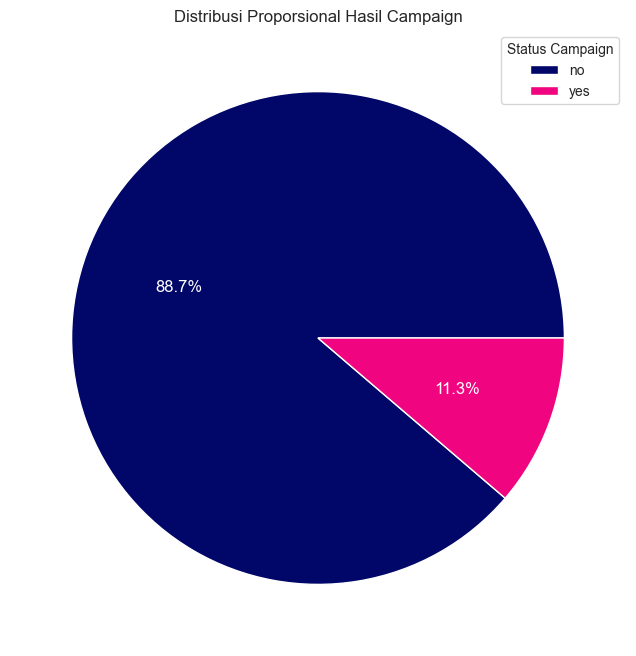

In [154]:
# Proporsi target variable
y_percentage = df_cleaned['y'].value_counts(normalize=True) *100

labels = y_percentage.index

plt.figure(figsize=(8, 8))
plt.pie(
    y_percentage,
    labels=labels,
    autopct='%1.1f%%',
    colors=['#010768', '#f00480'],
    textprops={'color': 'white', 'fontsize': 12}    
)
# Menampilkan legend
plt.legend(
    labels=labels,
    loc='best',  # Posisi legend otomatis
    title='Status Campaign' # Judul legend
)
plt.title('Distribusi Proporsional Hasil Campaign')
plt.show()

*Hasil campaign deposito yang telah dilakukan, di dominasi dengan status NO dengan proporsi 88.7%.*

# Analisis Eksplorasi Data (EDA)

## 1. Analisis Dasar: Distribusi Populasi & Efisiensi Konversi

**Tujuan:** Menganalisis sifat univariat dan bivariat setiap kolom untuk membangun pemahaman fundamental terhadap dataset.

### 1.1 Variabel Demografi

**Job**

In [156]:
# Hitung distribusi sebaran data
job_distribusi = df_cleaned['job'].value_counts().reset_index()
job_distribusi.columns = ['job', 'distribusi']

# Hitung proporsi data
job_proporsi = (df_cleaned['job'].value_counts(normalize=True) *100).reset_index()
job_proporsi.columns = ['job', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
job_distribusi_by_target = pd.crosstab(df_cleaned['job'], df_cleaned['y']).reset_index()
job_distribusi_by_target.columns = ['job', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
job_proporsi_by_target = (pd.crosstab(df_cleaned['job'], df_cleaned['y'], normalize='index')*100).reset_index()
job_proporsi_by_target.columns = ['job', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : job_distribusi + job_proporsi
merger_1 = pd.merge(job_distribusi, job_proporsi, how='left', on='job')

# Merger 2 : merger_1 + job_distribusi_by_target (mengambil hanya 'job' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    job_distribusi_by_target[['job', 'distribusi yes']], # Hanya ambil kolom 'job' dan 'distribusi yes'
    how='left',
    on='job'
)

# Merger 3 : merger_2 + job_proporsi_by_target (mengambil hanya 'job' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    job_proporsi_by_target[['job', 'proporsi yes (%)']], # Hanya ambil kolom 'job' dan 'proporsi yes (%)'
    how='left',
    on='job'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,job,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,student,875,2.125024,275,31.428571
1,retired,1718,4.172333,434,25.261932
2,unemployed,1014,2.462600,144,14.201183
3,admin.,10419,25.303575,1351,12.966695
4,management,2924,7.101224,328,11.217510
5,unknown,330,0.801438,37,11.212121
6,technician,6739,16.366330,730,10.832468
7,self-employed,1421,3.451039,149,10.485574
8,housemaid,1060,2.574315,106,10.000000
9,entrepreneur,1456,3.536040,124,8.516484


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3403957949.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(jobs_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3403957949.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(jobs_order, rotation=45, ha='right')


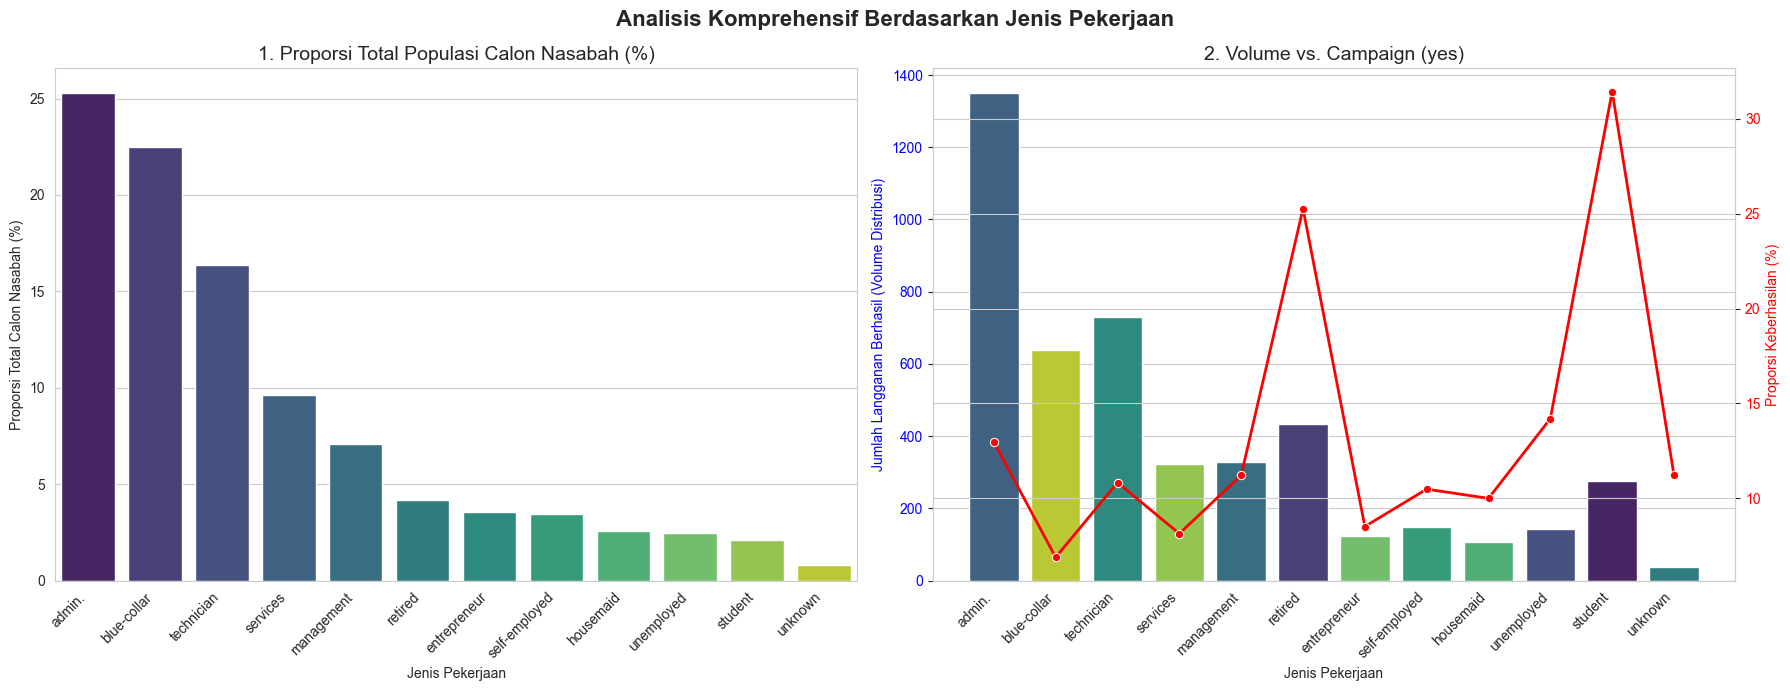

In [157]:
# Urutkan data
job_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
jobs_order = job_proporsi_order['job']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='job', y='proporsi %', data=job_proporsi_order,
    palette='viridis', hue='job', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Jenis Pekerjaan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(jobs_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='job', y='distribusi yes', data=final_merger_sorted, order=jobs_order,
    ax=ax_vol, palette='viridis', hue='job', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Jenis Pekerjaan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(jobs_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='job',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Jenis Pekerjaan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

- Student (konversi sangat tinggi meski populasi kecil).
- Retired (rasional sesuai teori, tapi performa luar biasa dibanding segmen aktif bekerja).
- Blue-collar & Entrepreneur — seharusnya punya potensi simpanan, tapi kenyataannya rendah.

**Status Pernikahan**

In [158]:
# Hitung distribusi sebaran data
marital_distribusi = df_cleaned['marital'].value_counts().reset_index()
marital_distribusi.columns = ['status', 'distribusi']

# Hitung proporsi data
marital_proporsi = (df_cleaned['marital'].value_counts(normalize=True) *100).reset_index()
marital_proporsi.columns = ['status', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
marital_distribusi_by_target = pd.crosstab(df_cleaned['marital'], df_cleaned['y']).reset_index()
marital_distribusi_by_target.columns = ['status', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
marital_proporsi_by_target = (pd.crosstab(df_cleaned['marital'], df_cleaned['y'], normalize='index')*100).reset_index()
marital_proporsi_by_target.columns = ['status', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : marital_distribusi + marital_proporsi
merger_1 = pd.merge(marital_distribusi, marital_proporsi, how='left', on='status')

# Merger 2 : merger_1 + marital_distribusi_by_target (mengambil hanya 'status marital' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    marital_distribusi_by_target[['status', 'distribusi yes']], # Hanya ambil kolom 'marital' dan 'distribusi yes'
    how='left',
    on='status'
)

# Merger 3 : merger_2 + marital_proporsi_by_target (mengambil hanya 'status marital' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    marital_proporsi_by_target[['status', 'proporsi yes (%)']], # Hanya ambil kolom 'marital' dan 'proporsi yes (%)'
    how='left',
    on='status'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,status,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,unknown,80,0.194288,12,15.000000
1,single,11564,28.084321,1620,14.008993
2,divorced,4611,11.198271,476,10.323140
3,married,24921,60.523120,2531,10.156093


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3298392731.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(marital_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3298392731.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(marital_order, rotation=45, ha='right')


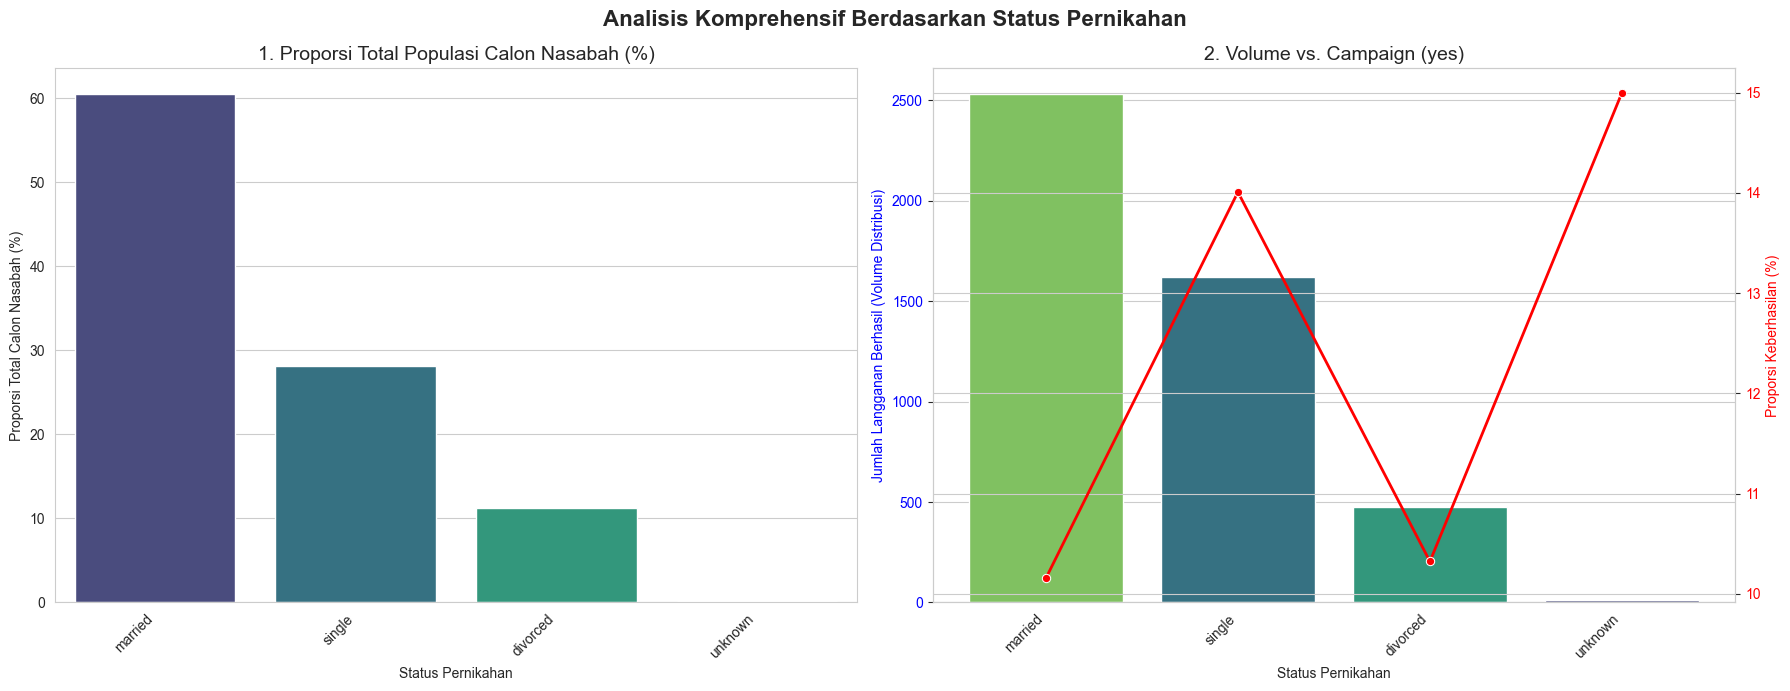

In [159]:
# Urutkan data
marital_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
marital_order = marital_proporsi_order['status']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='status', y='proporsi %', data=marital_proporsi_order,
    palette='viridis', hue='status', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status Pernikahan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(marital_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='status', y='distribusi yes', data=final_merger_sorted, order=marital_order,
    ax=ax_vol, palette='viridis', hue='status', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status Pernikahan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(marital_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='status',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Pernikahan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Makin besar tanggungan finansial (married) → makin rendah kecenderungan ambil deposito jangka panjang.
Makin bebas dari komitmen (single) → makin besar peluang konversi.

Jadi meskipun married adalah mayoritas, ROI kampanye lebih tinggi di segmen single.

**Tingkat Pendidikan**

In [160]:
# Hitung distribusi sebaran data
education_distribusi = df_cleaned['education'].value_counts().reset_index()
education_distribusi.columns = ['education', 'distribusi']

# Hitung proporsi data
education_proporsi = (df_cleaned['education'].value_counts(normalize=True) *100).reset_index()
education_proporsi.columns = ['education', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
education_distribusi_by_target = pd.crosstab(df_cleaned['education'], df_cleaned['y']).reset_index()
education_distribusi_by_target.columns = ['education', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
education_proporsi_by_target = (pd.crosstab(df_cleaned['education'], df_cleaned['y'], normalize='index')*100).reset_index()
education_proporsi_by_target.columns = ['education', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : education_distribusi + education_proporsi
merger_1 = pd.merge(education_distribusi, education_proporsi, how='left', on='education')

# Merger 2 : merger_1 + education_distribusi_by_target (mengambil hanya 'status pendidikan' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    education_distribusi_by_target[['education', 'distribusi yes']], # Hanya ambil kolom 'education' dan 'distribusi yes'
    how='left',
    on='education'
)

# Merger 3 : merger_2 + education_proporsi_by_target (mengambil hanya 'status pendidikan' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    education_proporsi_by_target[['education', 'proporsi yes (%)']], # Hanya ambil kolom 'education' dan 'proporsi yes (%)'
    how='left',
    on='education'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,education,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,illiterate,18,0.043715,4,22.222222
1,unknown,1730,4.201477,251,14.508671
2,university.degree,12164,29.541480,1669,13.720816
3,professional.course,5240,12.725860,595,11.354962
4,high.school,9512,23.100835,1031,10.838940
5,basic.4y,4176,10.141830,428,10.249042
6,basic.6y,2291,5.563921,188,8.206024
7,basic.9y,6045,14.680882,473,7.824648


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2521729512.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(education_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2521729512.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(education_order, rotation=45, ha='right')


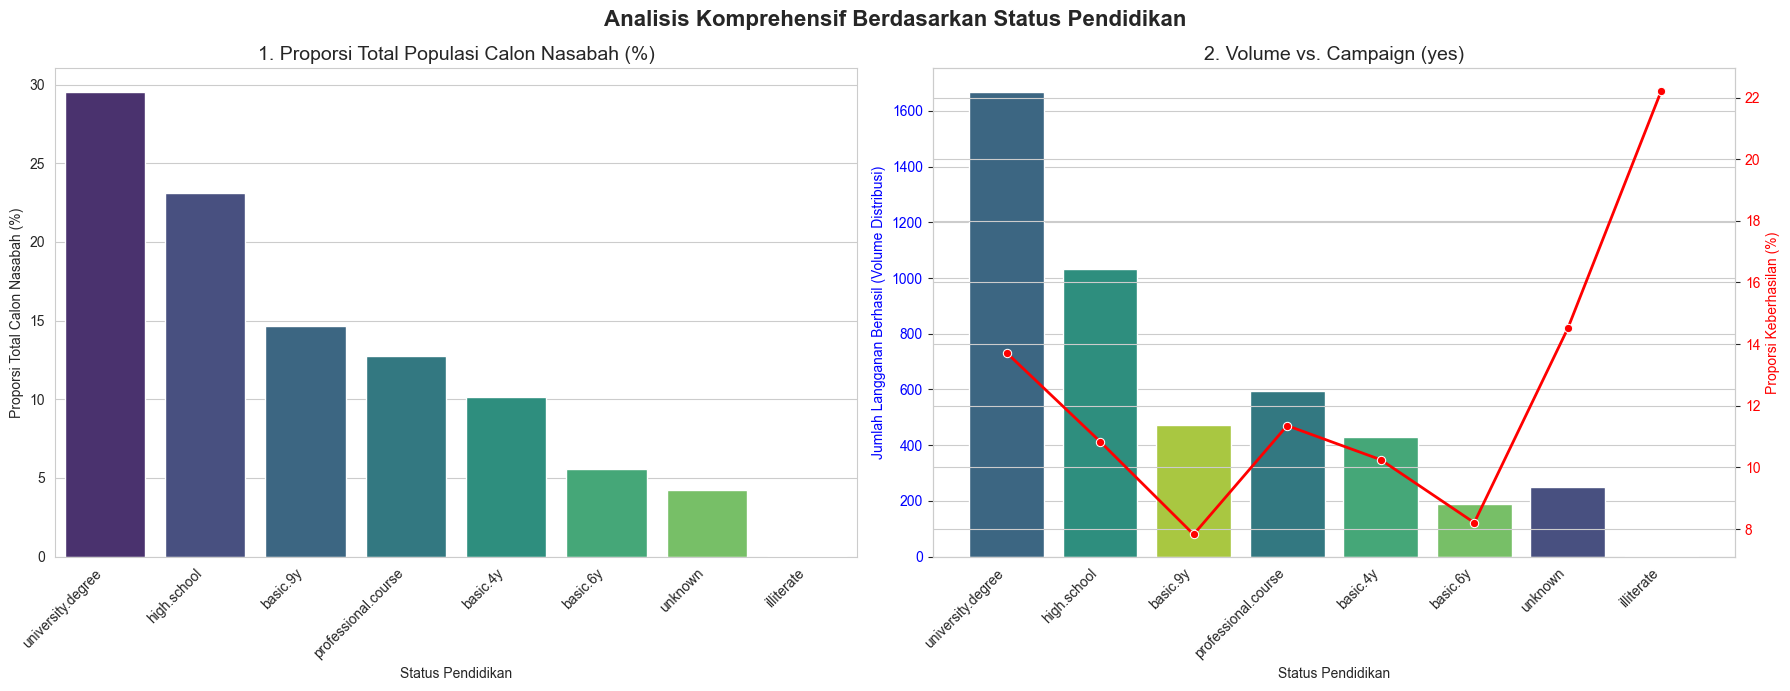

In [161]:
# Urutkan data
education_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
education_order = education_proporsi_order['education']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='education', y='proporsi %', data=education_proporsi_order,
    palette='viridis', hue='education', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status Pendidikan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(education_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='education', y='distribusi yes', data=final_merger_sorted, order=education_order,
    ax=ax_vol, palette='viridis', hue='education', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status Pendidikan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(education_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='education',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Pendidikan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()


Secara teori, makin tinggi pendidikan → makin tinggi literasi finansial → makin besar kemungkinan ikut deposito.

Namun di sini tidak linear.

Tingkat tertinggi (university) memang tinggi --> 13.7%, tapi kategori illiterate malah paling tinggi (22%).

Menunjukkan faktor emosional & kepercayaan sosial memainkan peran besar.

Illiterate dan Unknown cukup tinggi

Mungkin terdiri dari nasabah senior atau konservatif, yang lebih mudah dipengaruhi personal approach dari marketing officer.

Biasanya kelompok ini tidak aktif mencari informasi, tetapi sangat patuh pada rekomendasi langsung (trust-based decision).

Sedangkan Basic.9y populasi cukup besar (15%), tapi conversion rate justru terendah (7.8%).

Kemungkinan besar merupakan kelompok usia produktif dengan pendapatan fluktuatif, atau lebih memilih produk tabungan biasa ketimbang deposito.

**Rentan Umur**

In [162]:
# Definisikan bins dan label
bins = [17, 26, 36, 46, 56, 65, 99]
labels = ['17-25 (Dewasa Awal)', '26-35 (Dewasa Muda)', '36-45 (Paruh Baya Awal)', '46-55 (Paruh Baya Akhir)', '56-65 (Dewasa Akhir)', '65+ (Pensiun)']

# Membuat Kolom Baru 'age_group'
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=bins, labels=labels, right=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\4279851203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=bins, labels=labels, right=False)


In [163]:
# Hitung distribusi sebaran data
age_distribusi = df_cleaned['age_group'].value_counts().reset_index()
age_distribusi.columns = ['age_group', 'distribusi']

# Hitung proporsi data
age_proporsi = (df_cleaned['age_group'].value_counts(normalize=True) *100).reset_index()
age_proporsi.columns = ['age_group', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
age_distribusi_by_target = pd.crosstab(df_cleaned['age_group'], df_cleaned['y']).reset_index()
age_distribusi_by_target.columns = ['age_group', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
age_proporsi_by_target = (pd.crosstab(df_cleaned['age_group'], df_cleaned['y'], normalize='index')*100).reset_index()
age_proporsi_by_target.columns = ['age_group', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : age_distribusi + age_proporsi
merger_1 = pd.merge(age_distribusi, age_proporsi, how='left', on='age_group')

# Merger 2 : merger_1 + age_distribusi_by_target (mengambil hanya 'rentan umur' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    age_distribusi_by_target[['age_group', 'distribusi yes']], # Hanya ambil kolom 'age_group' dan 'distribusi yes'
    how='left',
    on='age_group'
)

# Merger 3 : merger_2 + age_proporsi_by_target (mengambil hanya 'rentan umur' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    age_proporsi_by_target[['age_group', 'proporsi yes (%)']], # Hanya ambil kolom 'age_group' dan 'proporsi yes (%)'
    how='left',
    on='age_group'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,age_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,65+ (Pensiun),662,1.607733,313,47.280967
1,17-25 (Dewasa Awal),1665,4.043618,349,20.960961
2,56-65 (Dewasa Akhir),2919,7.089081,428,14.662556
3,26-35 (Dewasa Muda),14844,36.050126,1740,11.721908
4,46-55 (Paruh Baya Akhir),8247,20.028657,717,8.694071
5,36-45 (Paruh Baya Awal),12839,31.180785,1092,8.505335


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2874036882.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(age_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2874036882.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(age_order, rotation=45, ha='right')


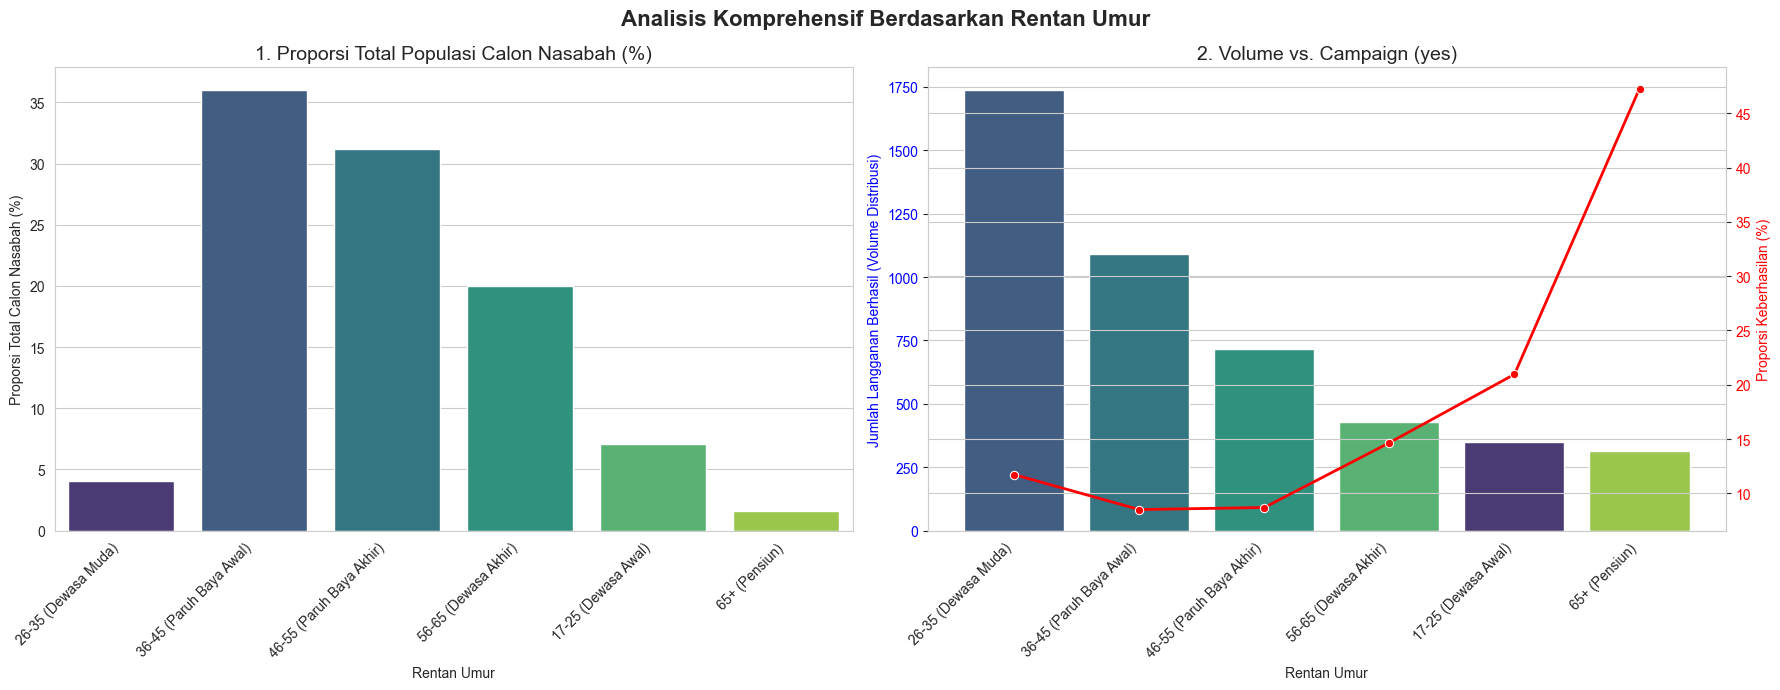

In [164]:
# Urutkan data
age_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
age_order = age_proporsi_order['age_group']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='age_group', y='proporsi %', data=age_proporsi_order,
    palette='viridis', hue='age_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Rentan Umur')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(age_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='age_group', y='distribusi yes', data=final_merger_sorted, order=age_order,
    ax=ax_vol, palette='viridis', hue='age_group', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Rentan Umur')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(age_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='age_group',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Rentan Umur', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Hubungan terbalik antara usia dan volume populasi:

Usia muda dan tua sama-sama minoritas populasi tapi punya konversi tinggi.

Usia produktif (26–50 tahun) mendominasi populasi tapi conversion rate rendah.

Motivasi finansial berbeda antar generasi:

60+: mencari keamanan dan stabilitas.

17–25: ingin belajar investasi jangka panjang.

26–50: fokus pengeluaran, pinjaman, dan risiko likuiditas.

Tingkat keberhasilan tertinggi berasal dari kelompok “low base but high intent” (60+ dan 17–25)
→ Target paling efisien untuk kampanye biaya rendah tapi hasil tinggi.

### 1.2 Status Finansial

**Status Kredit**

In [165]:
# Hitung distribusi sebaran data
default_distribusi = df_cleaned['default'].value_counts().reset_index()
default_distribusi.columns = ['default', 'distribusi']

# Hitung proporsi data
default_proporsi = (df_cleaned['default'].value_counts(normalize=True) *100).reset_index()
default_proporsi.columns = ['default', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
default_distribusi_by_target = pd.crosstab(df_cleaned['default'], df_cleaned['y']).reset_index()
default_distribusi_by_target.columns = ['default', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
default_proporsi_by_target = (pd.crosstab(df_cleaned['default'], df_cleaned['y'], normalize='index')*100).reset_index()
default_proporsi_by_target.columns = ['default', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : default_distribusi + default_proporsi
merger_1 = pd.merge(default_distribusi, default_proporsi, how='left', on='default')

# Merger 2 : merger_1 + default_distribusi_by_target (mengambil hanya 'status kredit' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    default_distribusi_by_target[['default', 'distribusi yes']], # Hanya ambil kolom 'default' dan 'distribusi yes'
    how='left',
    on='default'
)

# Merger 3 : merger_2 + default_proporsi_by_target (mengambil hanya 'status kredit' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    default_proporsi_by_target[['default', 'proporsi yes (%)']], # Hanya ambil kolom 'default' dan 'proporsi yes (%)'
    how='left',
    on='default'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,default,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,no,32577,79.116476,4196,12.880253
1,unknown,8596,20.876239,443,5.153560
2,yes,3,0.007286,0,0.000000


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1448315263.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(default_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1448315263.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(default_order, rotation=45, ha='right')


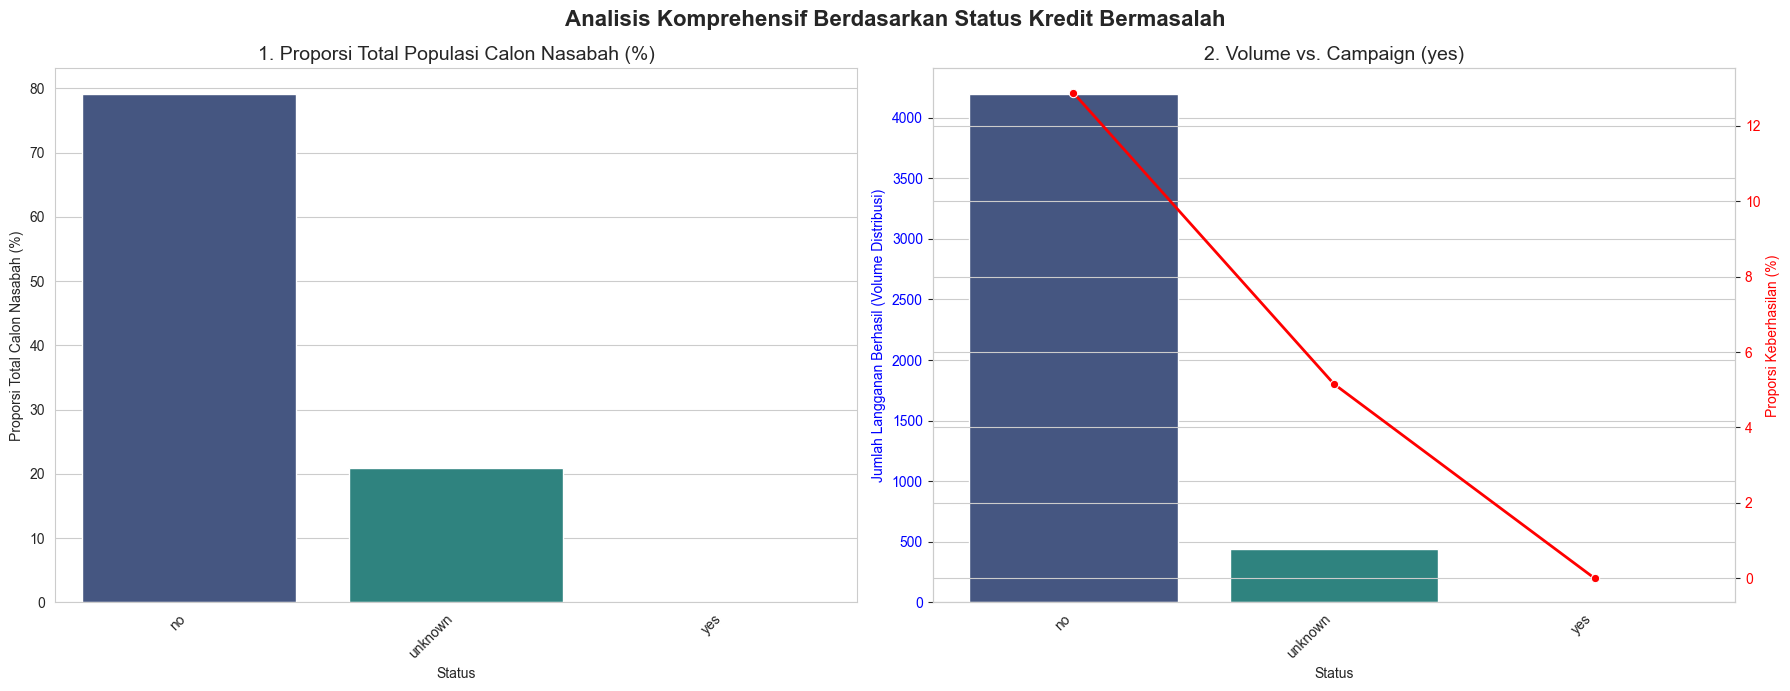

In [166]:
# Urutkan data
default_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
default_order = default_proporsi_order['default']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='default', y='proporsi %', data=default_proporsi_order,
    palette='viridis', hue='default', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(default_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='default', y='distribusi yes', data=final_merger_sorted, order=default_order,
    ax=ax_vol, palette='viridis', hue='default', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(default_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='default',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Kredit Bermasalah', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Default menjadi salah satu predictor terkuat terhadap keputusan investasi deposito.

Kualitas data (unknown) penting untuk diperbaiki, karena segmen ini bisa menyembunyikan potensi konversi.

**Pinjaman Perumahan**

In [167]:
# Hitung distribusi sebaran data
housing_distribusi = df_cleaned['housing'].value_counts().reset_index()
housing_distribusi.columns = ['housing', 'distribusi']

# Hitung proporsi data
housing_proporsi = (df_cleaned['housing'].value_counts(normalize=True) *100).reset_index()
housing_proporsi.columns = ['housing', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
housing_distribusi_by_target = pd.crosstab(df_cleaned['housing'], df_cleaned['y']).reset_index()
housing_distribusi_by_target.columns = ['housing', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
housing_proporsi_by_target = (pd.crosstab(df_cleaned['housing'], df_cleaned['y'], normalize='index')*100).reset_index()
housing_proporsi_by_target.columns = ['housing', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : housing_distribusi + housing_proporsi
merger_1 = pd.merge(housing_distribusi, housing_proporsi, how='left', on='housing')

# Merger 2 : merger_1 + housing_distribusi_by_target (mengambil hanya 'status pinjaman rumah' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    housing_distribusi_by_target[['housing', 'distribusi yes']], # Hanya ambil kolom 'housing' dan 'distribusi yes'
    how='left',
    on='housing'
)

# Merger 3 : merger_2 + housing_proporsi_by_target (mengambil hanya 'status pinjaman rumah' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    housing_proporsi_by_target[['housing', 'proporsi yes (%)']], # Hanya ambil kolom 'housing' dan 'proporsi yes (%)'
    how='left',
    on='housing'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,housing,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,yes,21571,52.387313,2507,11.622085
1,no,18615,45.208374,2025,10.878324
2,unknown,990,2.404313,107,10.808081


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3065165398.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(housing_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3065165398.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(housing_order, rotation=45, ha='right')


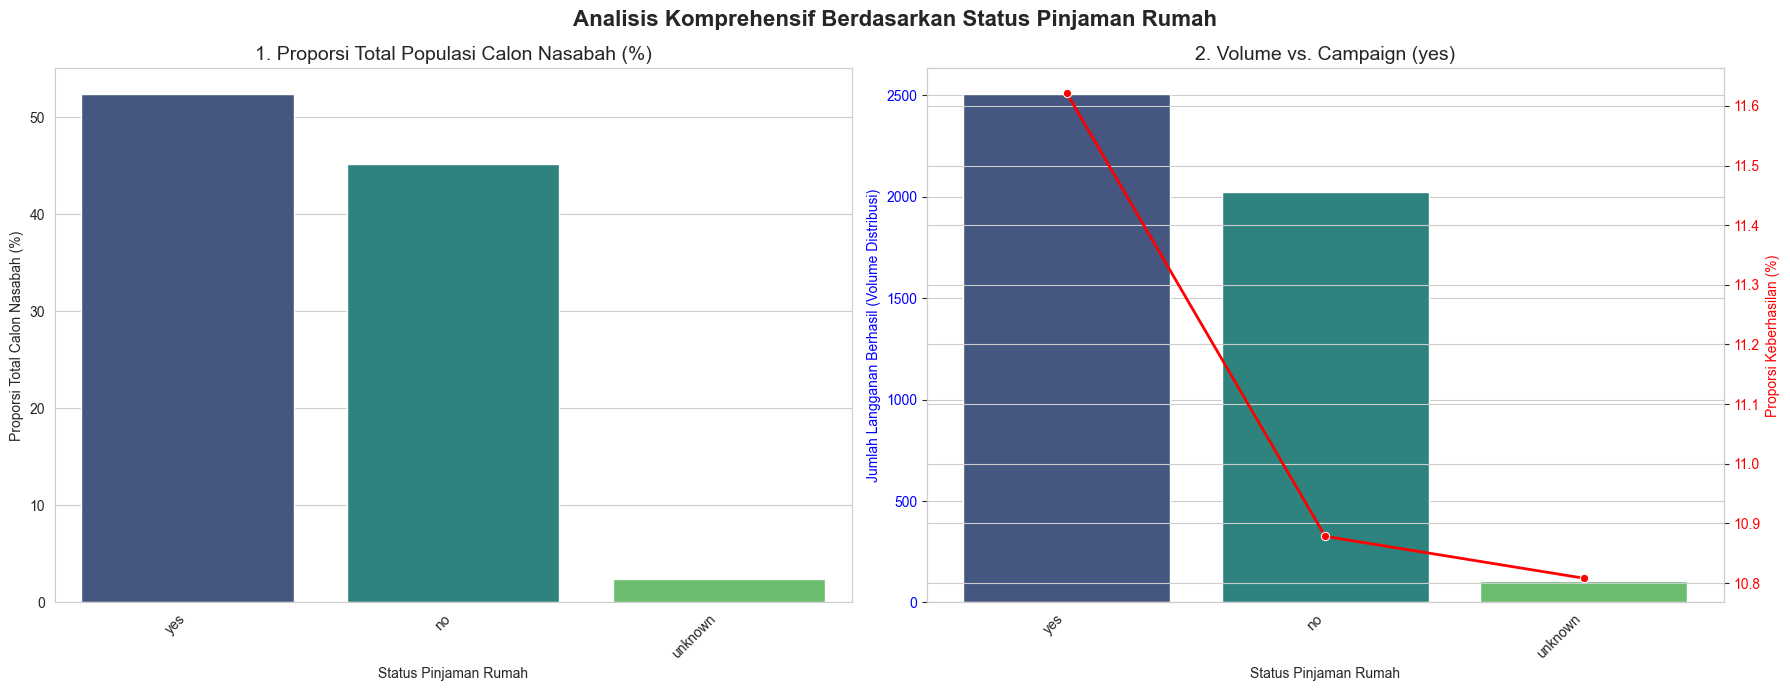

In [168]:
# Urutkan data
housing_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
housing_order = housing_proporsi_order['housing']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='housing', y='proporsi %', data=housing_proporsi_order,
    palette='viridis', hue='housing', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status Pinjaman Rumah')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(housing_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='housing', y='distribusi yes', data=final_merger_sorted, order=housing_order,
    ax=ax_vol, palette='viridis', hue='housing', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status Pinjaman Rumah')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(housing_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='housing',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Pinjaman Rumah', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Hasil ini sedikit berbeda dari teori klasik likuiditas, namun masuk akal secara perilaku modern
nasabah yang punya KPR biasanya juga punya penghasilan tetap, profil kredit bagus, dan lebih paham produk bank.
Jadi mereka lebih percaya dan mampu membuka deposito. 

**Pinjaman Pribadi**

In [169]:
# Hitung distribusi sebaran data
loan_distribusi = df_cleaned['loan'].value_counts().reset_index()
loan_distribusi.columns = ['loan', 'distribusi']

# Hitung proporsi data
loan_proporsi = (df_cleaned['loan'].value_counts(normalize=True) *100).reset_index()
loan_proporsi.columns = ['loan', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
loan_distribusi_by_target = pd.crosstab(df_cleaned['loan'], df_cleaned['y']).reset_index()
loan_distribusi_by_target.columns = ['loan', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
loan_proporsi_by_target = (pd.crosstab(df_cleaned['loan'], df_cleaned['y'], normalize='index')*100).reset_index()
loan_proporsi_by_target.columns = ['loan', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : loan_distribusi + loan_proporsi
merger_1 = pd.merge(loan_distribusi, loan_proporsi, how='left', on='loan')

# Merger 2 : merger_1 + loan_distribusi_by_target (mengambil hanya 'status pinjaman' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    loan_distribusi_by_target[['loan', 'distribusi yes']], # Hanya ambil kolom 'loan' dan 'distribusi yes'
    how='left',
    on='loan'
)

# Merger 3 : merger_2 + loan_proporsi_by_target (mengambil hanya 'status pinjaman' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    loan_proporsi_by_target[['loan', 'proporsi yes (%)']], # Hanya ambil kolom 'loan' dan 'proporsi yes (%)'
    how='left',
    on='loan'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,loan,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,no,33938,82.421799,3849,11.341269
1,yes,6248,15.173888,683,10.931498
2,unknown,990,2.404313,107,10.808081


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2965030522.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(loan_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2965030522.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(loan_order, rotation=45, ha='right')


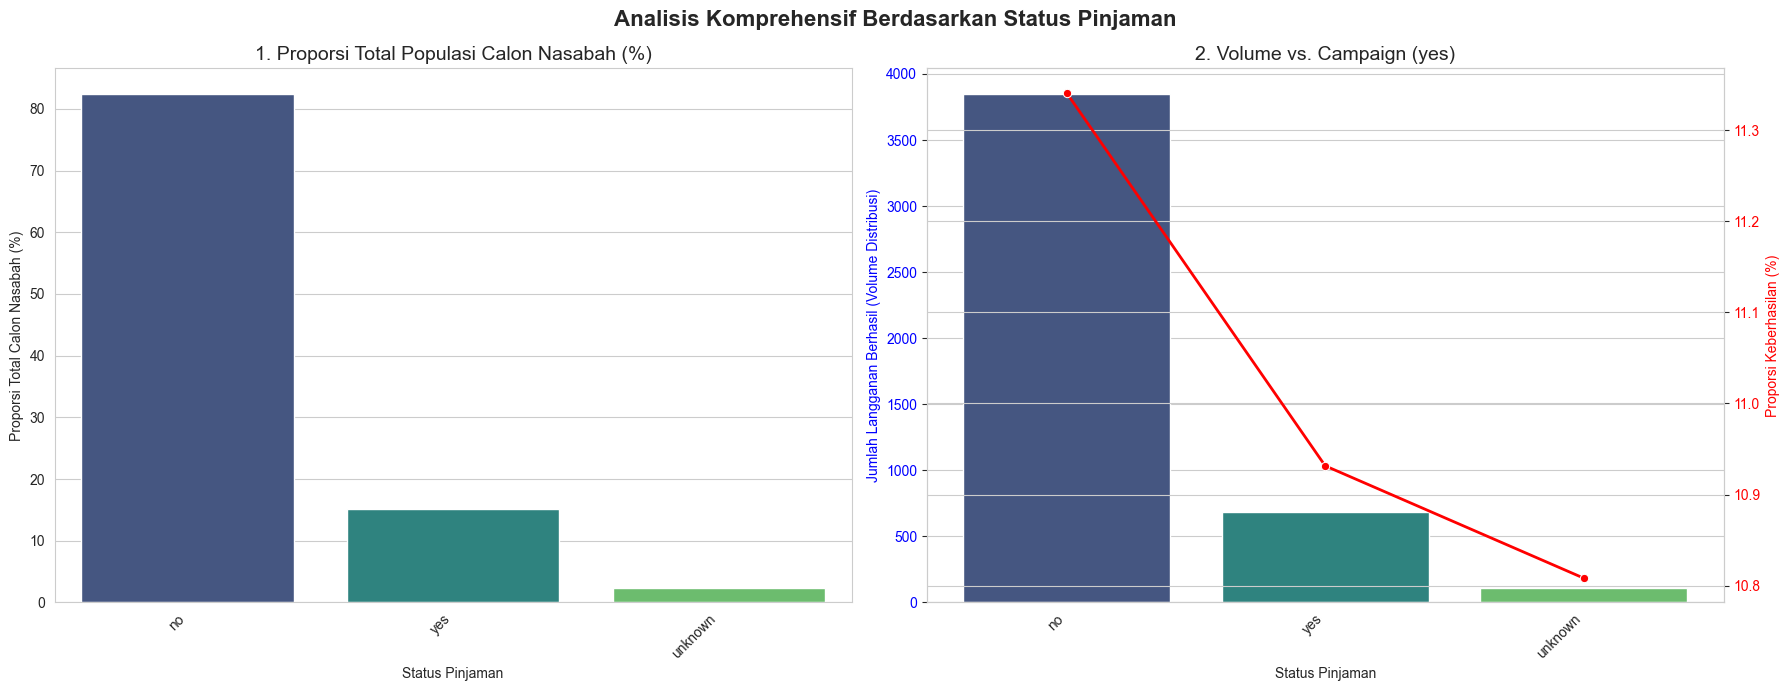

In [170]:
# Urutkan data
loan_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
loan_order = loan_proporsi_order['loan']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='loan', y='proporsi %', data=loan_proporsi_order,
    palette='viridis', hue='loan', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status Pinjaman')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(loan_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='loan', y='distribusi yes', data=final_merger_sorted, order=loan_order,
    ax=ax_vol, palette='viridis', hue='loan', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status Pinjaman')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(loan_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='loan',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Pinjaman', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Mayoritas nasabah (82%) tidak memiliki pinjaman pribadi, dan mereka memiliki conversion rate tertinggi (11.3%).
Artinya: nasabah yang tidak punya utang konsumtif lebih cenderung membuka deposito.

Nasabah dengan personal loan (15%) justru sedikit lebih jarang ambil deposito (10.9%).
Ini selaras dengan teori ekonomi klasik — beban utang konsumtif menurunkan kemampuan menabung.

### 1.3 Interaksi Campaign

**Type komunikasi**

In [171]:
# Hitung distribusi sebaran data
contact_distribusi = df_cleaned['contact'].value_counts().reset_index()
contact_distribusi.columns = ['contact', 'distribusi']

# Hitung proporsi data
contact_proporsi = (df_cleaned['contact'].value_counts(normalize=True) *100).reset_index()
contact_proporsi.columns = ['contact', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
contact_distribusi_by_target = pd.crosstab(df_cleaned['contact'], df_cleaned['y']).reset_index()
contact_distribusi_by_target.columns = ['contact', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
contact_proporsi_by_target = (pd.crosstab(df_cleaned['contact'], df_cleaned['y'], normalize='index')*100).reset_index()
contact_proporsi_by_target.columns = ['contact', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : contact_distribusi + contact_proporsi
merger_1 = pd.merge(contact_distribusi, contact_proporsi, how='left', on='contact')

# Merger 2 : merger_1 + contact_distribusi_by_target (mengambil hanya 'jenis contact' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    contact_distribusi_by_target[['contact', 'distribusi yes']], # Hanya ambil kolom 'contact' dan 'distribusi yes'
    how='left',
    on='contact'
)

# Merger 3 : merger_2 + contact_proporsi_by_target (mengambil hanya 'jenis contact' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    contact_proporsi_by_target[['contact', 'proporsi yes (%)']], # Hanya ambil kolom 'contact' dan 'proporsi yes (%)'
    how='left',
    on='contact'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,contact,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,cellular,26135,63.47144,3852,14.738856
1,telephone,15041,36.52856,787,5.232365


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\505728905.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(contact_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\505728905.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(contact_order, rotation=45, ha='right')


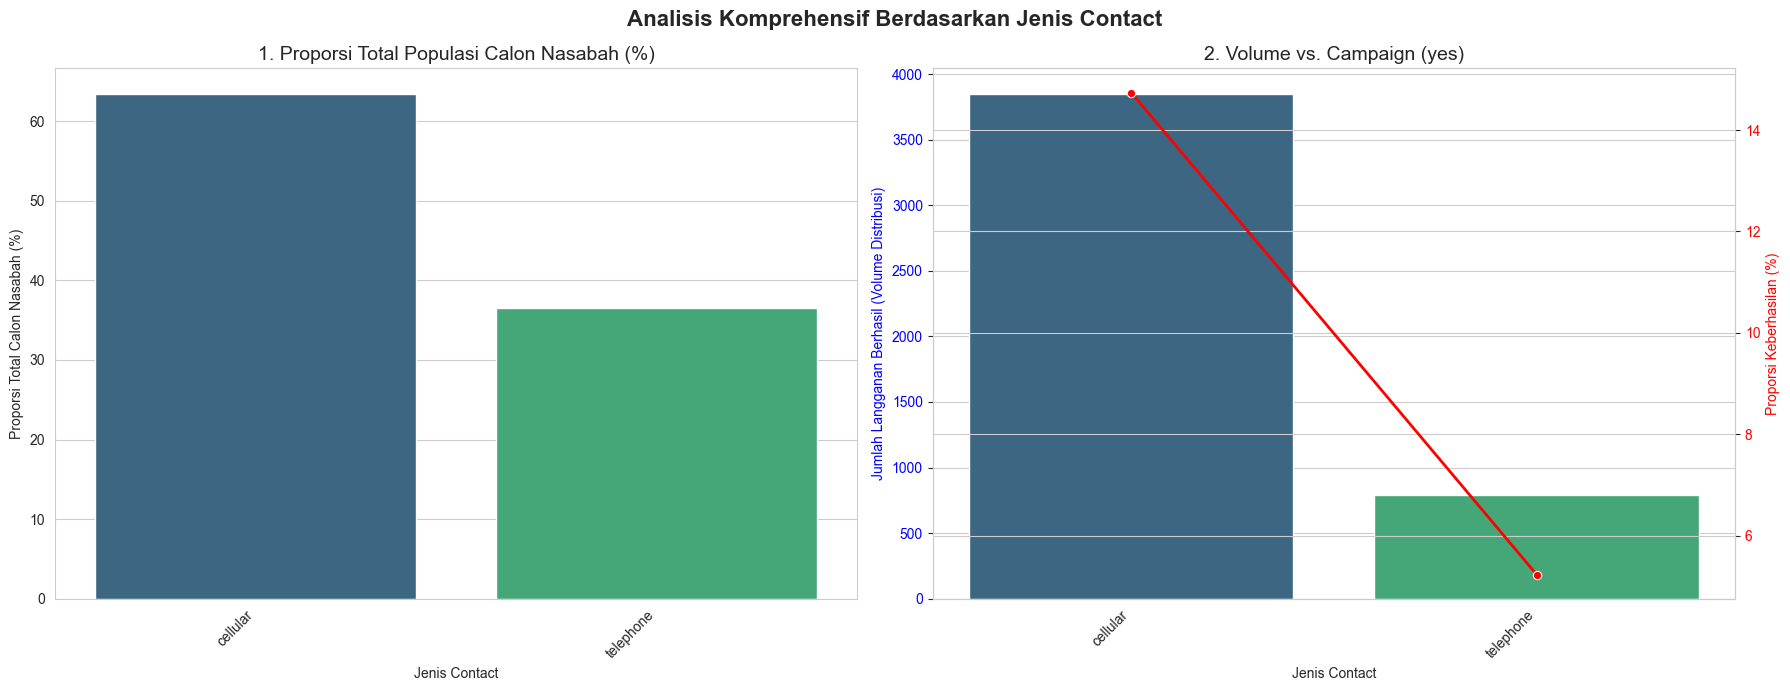

In [172]:
# Urutkan data
contact_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
contact_order = contact_proporsi_order['contact']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='contact', y='proporsi %', data=contact_proporsi_order,
    palette='viridis', hue='contact', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Jenis Contact')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(contact_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='contact', y='distribusi yes', data=final_merger_sorted, order=contact_order,
    ax=ax_vol, palette='viridis', hue='contact', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Jenis Contact')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(contact_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='contact',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Jenis Contact', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()


- Kontak via cellular menghasilkan konversi 3× lebih tinggi dibanding telepon rumah. Ini menggambarkan perubahan perilaku nasabah ke arah mobile-first.

*Kampanye deposito paling efektif dilakukan lewat channel mobile (telemarketing HP, SMS blast, atau WhatsApp banking).*


**Bulan kontak**

In [173]:
# Hitung distribusi sebaran data
month_distribusi = df_cleaned['month'].value_counts().reset_index()
month_distribusi.columns = ['month', 'distribusi']

# Hitung proporsi data
month_proporsi = (df_cleaned['month'].value_counts(normalize=True) *100).reset_index()
month_proporsi.columns = ['month', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
month_distribusi_by_target = pd.crosstab(df_cleaned['month'], df_cleaned['y']).reset_index()
month_distribusi_by_target.columns = ['month', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
month_proporsi_by_target = (pd.crosstab(df_cleaned['month'], df_cleaned['y'], normalize='index')*100).reset_index()
month_proporsi_by_target.columns = ['month', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : month_distribusi + month_proporsi
merger_1 = pd.merge(month_distribusi, month_proporsi, how='left', on='month')

# Merger 2 : merger_1 + month_distribusi_by_target (mengambil hanya 'rentan bulan' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    month_distribusi_by_target[['month', 'distribusi yes']], # Hanya ambil kolom 'month' dan 'distribusi yes'
    how='left',
    on='month'
)

# Merger 3 : merger_2 + month_proporsi_by_target (mengambil hanya 'rentan bulan' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    month_proporsi_by_target[['month', 'proporsi yes (%)']], # Hanya ambil kolom 'month' dan 'proporsi yes (%)'
    how='left',
    on='month'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,month,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,mar,546,1.326015,276,50.549451
1,dec,182,0.442005,89,48.901099
2,sep,570,1.384302,256,44.912281
3,oct,717,1.741306,315,43.933054
4,apr,2631,6.389644,539,20.486507
5,aug,6176,14.999029,655,10.605570
6,jun,5318,12.915290,559,10.511470
7,nov,4100,9.957257,416,10.146341
8,jul,7169,17.410628,648,9.038918
9,may,13767,33.434525,886,6.435680


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1142019919.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(month_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1142019919.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(month_order, rotation=45, ha='right')


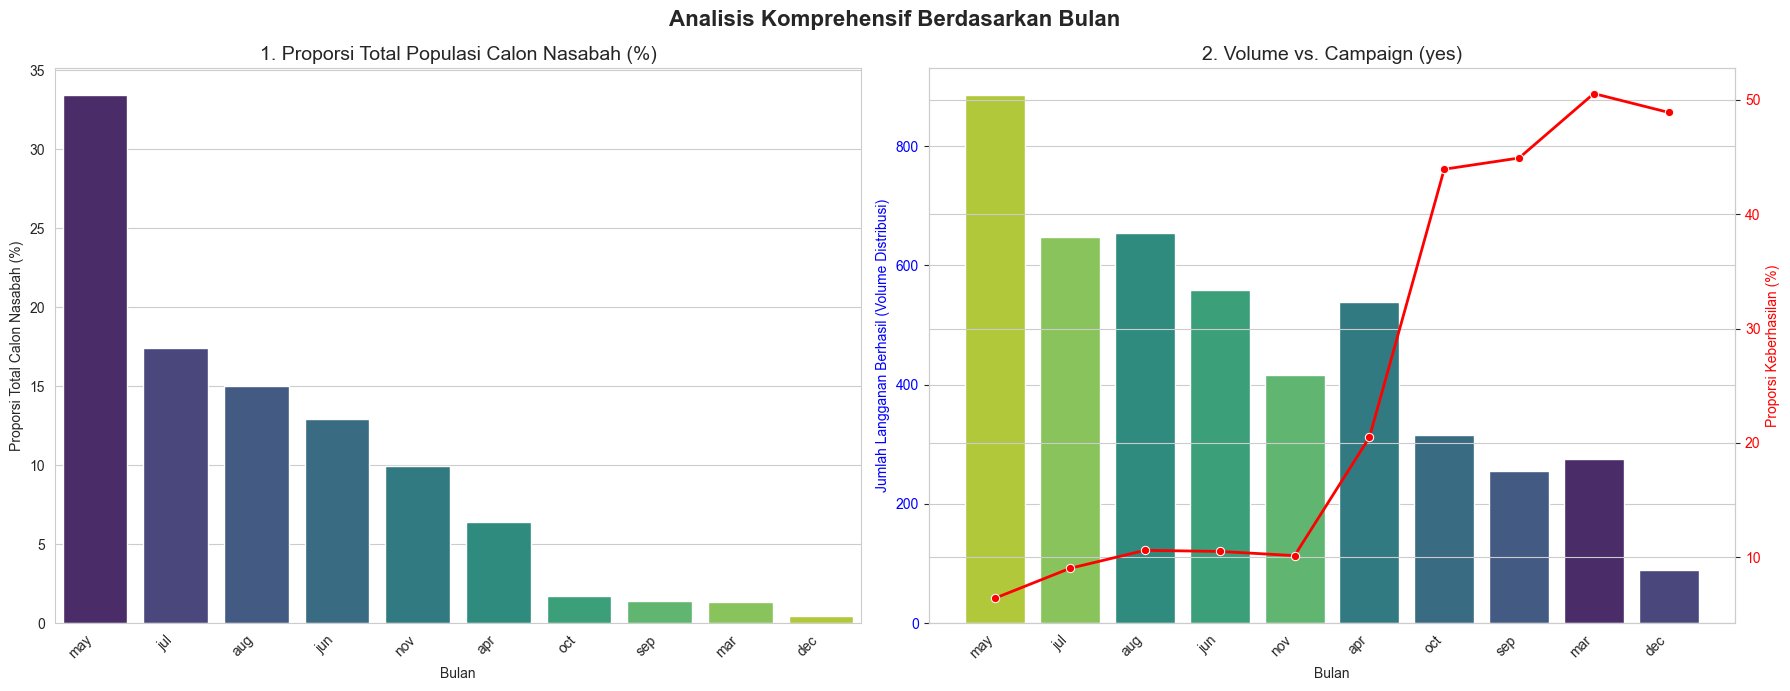

In [174]:
# Urutkan data
month_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
month_order = month_proporsi_order['month']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='month', y='proporsi %', data=month_proporsi_order,
    palette='viridis', hue='month', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Bulan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(month_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='month', y='distribusi yes', data=final_merger_sorted, order=month_order,
    ax=ax_vol, palette='viridis', hue='month', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Bulan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(month_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='month',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Bulan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Maret – Oktober punya tingkat keberhasilan tinggi (terutama Maret, Desember).

Mei–Juli justru periode dengan volume kontak terbesar tapi efektivitas rendah.

Maret & Desember memiliki konversi > 48%!

Meski kontak sedikit, rasio keberhasilan luar biasa tinggi.

Ini menunjukkan kampanye pada bulan ini lebih tepat waktu dan lebih berkualitas.

Mei jadi anomali:

Kampanye paling masif (33% dari seluruh kontak),

Tapi tingkat konversinya terendah (6.4%) → indikasi over-contacting / fatigue effect.

**Jumlah kontak dilakukan pada kampanye saat ini**

In [175]:
# Tentukan batas (bins) dan nama kategori (labels)
bins = [0, 3, 7, 15, np.inf] # np.inf digunakan untuk batas atas tak terbatas
labels = ['Low (1-3)', 'Medium (4-7)', 'High (8-15)', 'Extreme (>15)']

# Kolom baru campaign_group
df_cleaned['campaign_group'] = pd.cut(df_cleaned['campaign'], bins=bins, labels=labels, right=True, include_lowest=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2116476579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['campaign_group'] = pd.cut(df_cleaned['campaign'], bins=bins, labels=labels, right=True, include_lowest=True)


In [176]:
# Tentukan nama kolom klustering yang baru
kluster_col = 'campaign_group'

# 1. Hitung distribusi sebaran data
campaign_distribusi = df_cleaned[kluster_col].value_counts().reset_index()
campaign_distribusi.columns = [kluster_col, 'distribusi']

# 2. Hitung proporsi data
campaign_proporsi = (df_cleaned[kluster_col].value_counts(normalize=True) * 100).reset_index()
campaign_proporsi.columns = [kluster_col, 'proporsi total (%)'] # Mengganti nama kolom untuk kejelasan

# 3. Hitung distribusi sebaran data dengan variable target 'y'
campaign_distribusi_by_target = pd.crosstab(df_cleaned[kluster_col], df_cleaned['Y']).reset_index()
campaign_distribusi_by_target.columns = [kluster_col, 'distribusi no', 'distribusi yes']

# 4. Hitung Proporsi data dengan variable target 'y' (Tingkat Konversi %)
campaign_proporsi_by_target = (pd.crosstab(df_cleaned[kluster_col], df_cleaned['Y'], normalize='index') * 100).reset_index()
campaign_proporsi_by_target.columns = [kluster_col, 'proporsi no (%)', 'proporsi yes %'] # CR% adalah nama yang lebih baik

# 5. Merger Semua Data
# Merger 1 : campaign_distribusi + campaign_proporsi
merger_1 = pd.merge(campaign_distribusi, campaign_proporsi, how='left', on=kluster_col)

# Merger 2 : merger_1 + campaign_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    campaign_distribusi_by_target[[kluster_col, 'distribusi yes']],
    how='left',
    on=kluster_col
)

# Merger 3 : merger_2 + campaign_proporsi_by_target
final_merger = pd.merge(
    merger_2,
    campaign_proporsi_by_target[[kluster_col, 'proporsi yes %']],
    how='left',
    on=kluster_col
)

# 6. Sort hasil merger
final_merger_sorted_kluster = final_merger.sort_values(by='proporsi yes %', ascending=False).reset_index(drop=True)
final_merger_sorted_kluster

,campaign_group,distribusi,proporsi total (%),distribusi yes,proporsi yes %
0,Low (1-3),33542,81.460074,4084,12.175780
1,Medium (4-7),5857,14.224305,482,8.229469
2,High (8-15),1422,3.453468,68,4.781997
3,Extreme (>15),355,0.862153,5,1.408451


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2343510301.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(campaign_group_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2343510301.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(campaign_group_order, rotation=45, ha='right')


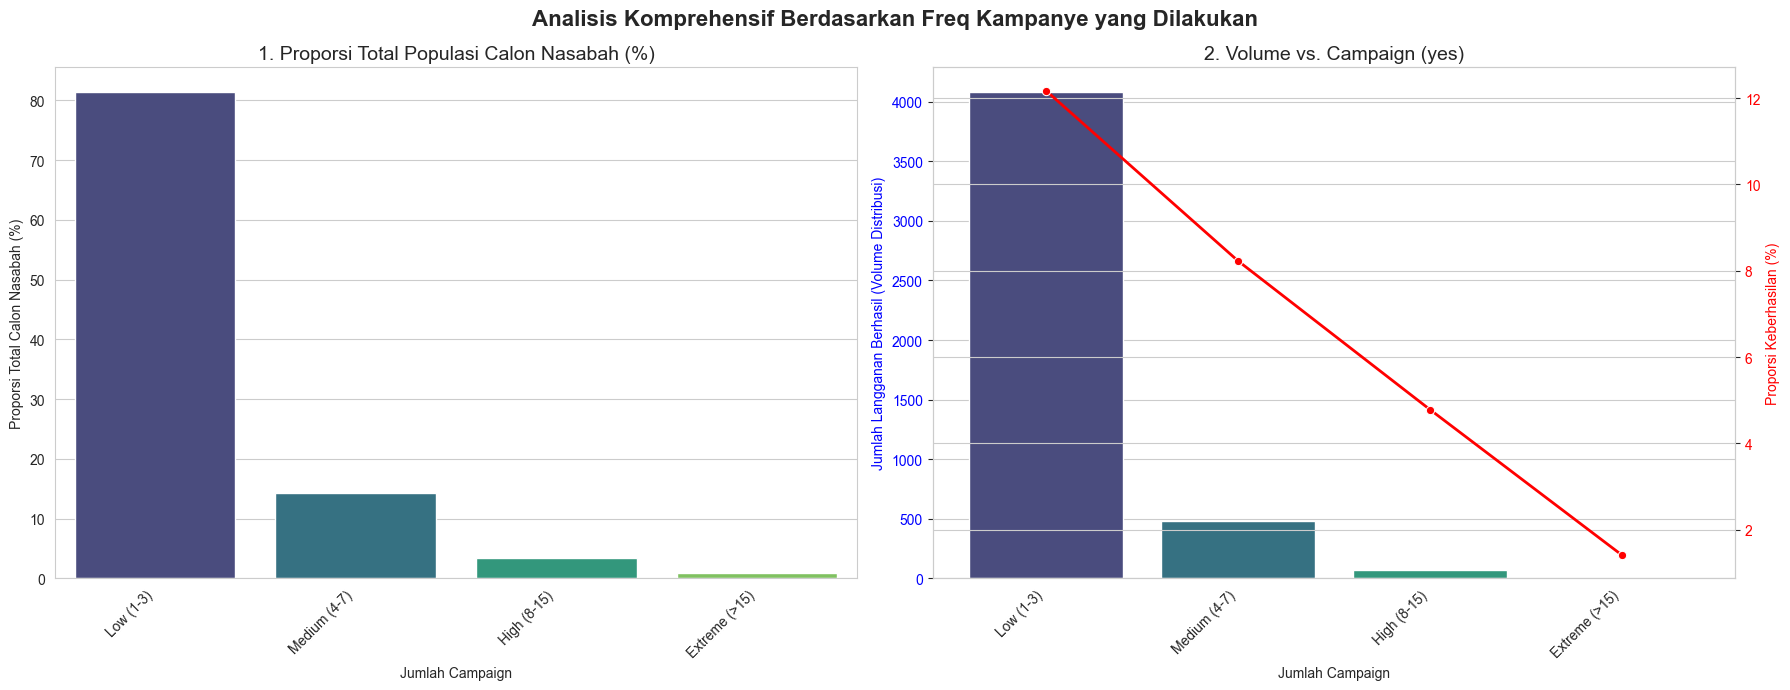

In [177]:

# Urutkan data
campaign_group_proporsi_order = final_merger_sorted_kluster.sort_values(by='proporsi total (%)', ascending=False)
campaign_group_order = campaign_group_proporsi_order['campaign_group']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) 

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='campaign_group', y='proporsi total (%)', data=campaign_group_proporsi_order,
    palette='viridis', hue='campaign_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Jumlah Campaign')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(campaign_group_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='campaign_group', y='distribusi yes', data=campaign_group_proporsi_order, order=campaign_group_order,
    ax=ax_vol, palette='viridis', hue='campaign_group', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Jumlah Campaign')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(campaign_group_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='campaign_group',
    y='proporsi yes %',
    data=campaign_group_proporsi_order,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Freq Kampanye yang Dilakukan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

- Makin sedikit kampanye yang dilakukan saat ini, secara koefisien keberhasilan kampanye meningkat
- Semakinn banyak di lakukan, malah menjadi tidak efektif

**Durasi panggilan pada saat campaign dilakukan**

In [178]:
# Nilai maks 4918. Kita gunakan 4919 sebagai batas atas agar 4918 termasuk.
MAX_DURATION = 4918 

# Tentukan batas waktu (dalam detik). 
bins = [
    0, 
    100, 
    200, 
    400, 
    600, 
    1000, 
    MAX_DURATION + 1 
]

labels = [
    '< 100s (Singkat/Tidak Tertarik)',
    '100s - 200s (Tertarik Awal)',
    '200s - 400s (Menunjukkan Engagement)',
    '400s - 600s (Diskusi Serius)',
    '600s - 1000s (Komitmen Lebih Dalam)',
    '> 1000s (Sangat Serius/High Interest)'
]

# --- 2. Buat Kolom Kategorikal Baru (`duration_stage`) ---
df_cleaned['duration_stage'] = pd.cut(
    df_cleaned['duration'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True,  # Memasukkan nilai 0
    right=False           # Menggunakan batas kiri tertutup: [100, 200) -> 100 masuk, 200 tidak masuk
)

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2859867013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['duration_stage'] = pd.cut(


In [179]:
# Hitung distribusi sebaran data
duration_stage_distribusi = df_cleaned['duration_stage'].value_counts().reset_index()
duration_stage_distribusi.columns = ['duration_stage', 'distribusi']

# Hitung proporsi data
duration_stage_proporsi = (df_cleaned['duration_stage'].value_counts(normalize=True) *100).reset_index()
duration_stage_proporsi.columns = ['duration_stage', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
duration_stage_distribusi_by_target = pd.crosstab(df_cleaned['duration_stage'], df_cleaned['y']).reset_index()
duration_stage_distribusi_by_target.columns = ['duration_stage', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
duration_stage_proporsi_by_target = (pd.crosstab(df_cleaned['duration_stage'], df_cleaned['y'], normalize='index')*100).reset_index()
duration_stage_proporsi_by_target.columns = ['duration_stage', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : duration_stage_distribusi + duration_stage_proporsi
merger_1 = pd.merge(duration_stage_distribusi, duration_stage_proporsi, how='left', on='duration_stage')

# Merger 2 : merger_1 + duration_stage_distribusi_by_target (mengambil hanya 'rentan lamanya kontak panggilan' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    duration_stage_distribusi_by_target[['duration_stage', 'distribusi yes']], # Hanya ambil kolom 'duration_stage' dan 'distribusi yes'
    how='left',
    on='duration_stage'
)

# Merger 3 : merger_2 + duration_stage_proporsi_by_target (mengambil hanya 'rentan lamanya kontak panggilan' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    duration_stage_proporsi_by_target[['duration_stage', 'proporsi yes (%)']], # Hanya ambil kolom 'duration_stage' dan 'proporsi yes (%)'
    how='left',
    on='duration_stage'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,duration_stage,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,> 1000s (Sangat Serius/High Interest),961,2.333884,570,59.313215
1,600s - 1000s (Komitmen Lebih Dalam),2517,6.112784,1120,44.497418
2,400s - 600s (Diskusi Serius),3721,9.036818,859,23.085192
3,200s - 400s (Menunjukkan Engagement),11334,27.525743,1384,12.211046
4,100s - 200s (Tertarik Awal),12764,30.998640,628,4.920088
5,< 100s (Singkat/Tidak Tertarik),9879,23.992131,78,0.789554


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\975695705.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(duration_stage_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\975695705.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(duration_stage_order, rotation=45, ha='right')


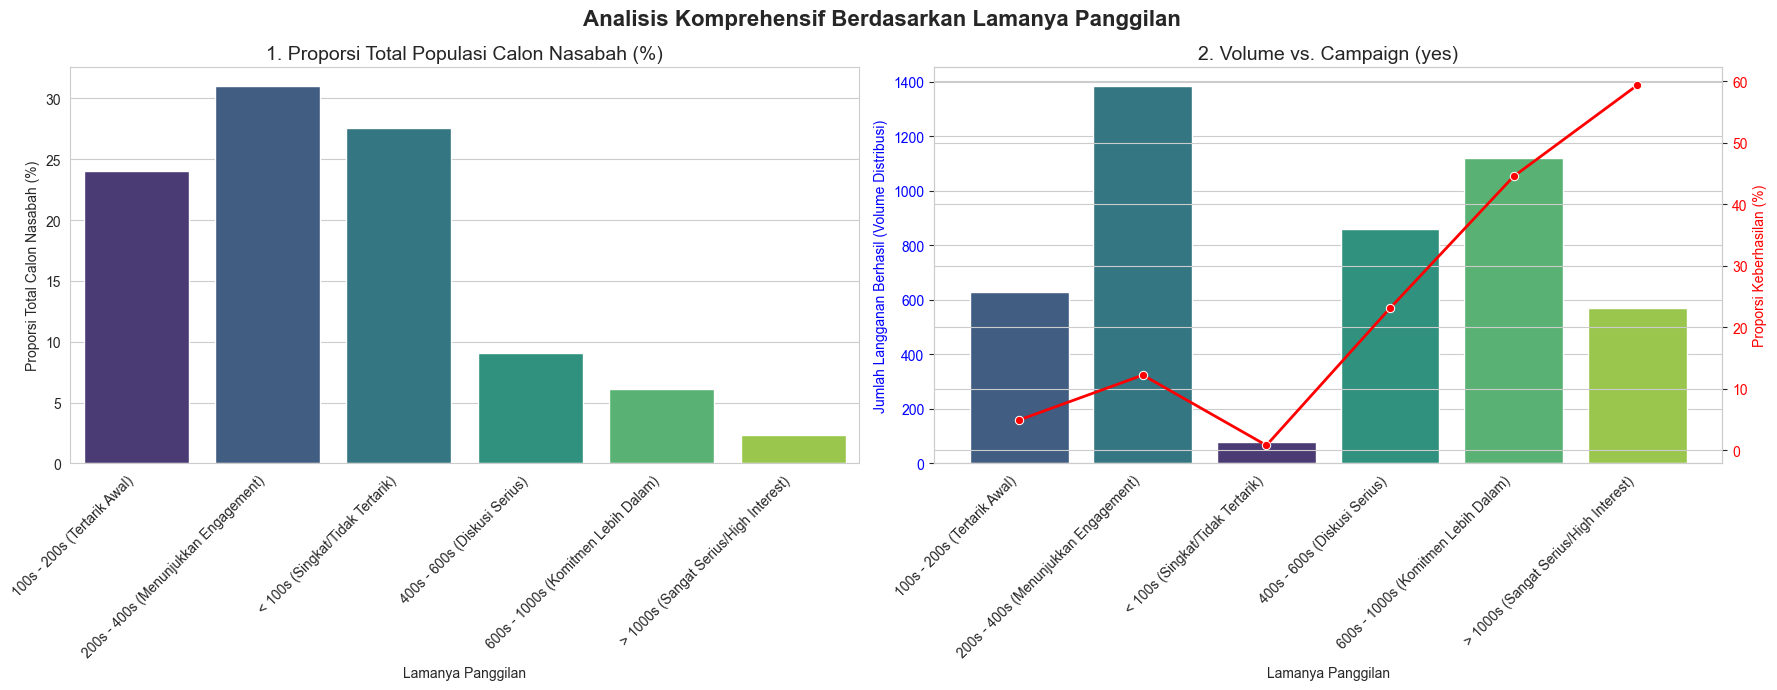

In [180]:
# Urutkan data
duration_stage_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
duration_stage_order = duration_stage_proporsi_order['duration_stage']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='duration_stage', y='proporsi %', data=duration_stage_proporsi_order,
    palette='viridis', hue='duration_stage', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Lamanya Panggilan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(duration_stage_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='duration_stage', y='distribusi yes', data=duration_stage_proporsi_order, order=duration_stage_order,
    ax=ax_vol, palette='viridis', hue='duration_stage', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Lamanya Panggilan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(duration_stage_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='duration_stage',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Lamanya Panggilan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

**Jumlah hari terakhir dilakukan kontak**

In [181]:
# Hitung distribusi sebaran data
pdays_distribusi = df_cleaned['pdays'].value_counts().reset_index()
pdays_distribusi.columns = ['pdays', 'distribusi']

# Hitung proporsi data
pdays_proporsi = (df_cleaned['pdays'].value_counts(normalize=True) *100).reset_index()
pdays_proporsi.columns = ['pdays', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
pdays_distribusi_by_target = pd.crosstab(df_cleaned['pdays'], df_cleaned['y']).reset_index()
pdays_distribusi_by_target.columns = ['pdays', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
pdays_proporsi_by_target = (pd.crosstab(df_cleaned['pdays'], df_cleaned['y'], normalize='index')*100).reset_index()
pdays_proporsi_by_target.columns = ['pdays', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : pdays_distribusi + pdays_proporsi
merger_1 = pd.merge(pdays_distribusi, pdays_proporsi, how='left', on='pdays')

# Merger 2 : merger_1 + pdays_distribusi_by_target (mengambil hanya 'rentan jarak kontak terakhir' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    pdays_distribusi_by_target[['pdays', 'distribusi yes']], # Hanya ambil kolom 'pdays' dan 'distribusi yes'
    how='left',
    on='pdays'
)

# Merger 3 : merger_2 + pdays_proporsi_by_target (mengambil hanya 'rentan jarak kontak terakhir' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    pdays_proporsi_by_target[['pdays', 'proporsi yes (%)']], # Hanya ambil kolom 'pdays' dan 'proporsi yes (%)'
    how='left',
    on='pdays'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,pdays,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,27,1,0.002429,1,100.000000
1,26,1,0.002429,1,100.000000
2,25,1,0.002429,1,100.000000
3,21,2,0.004857,2,100.000000
4,13,36,0.087430,28,77.777778
5,6,412,1.000583,289,70.145631
6,3,439,1.066155,298,67.881549
7,7,60,0.145716,40,66.666667
8,0,15,0.036429,10,66.666667
9,8,18,0.043715,12,66.666667


*Dilakukan grouping pada nilai 999, yang mana diasumsikan sebagai calon customer dengan status belum pernah dihubungi*

In [182]:
# 1. Membuat variabel p_days_group baru
df_cleaned['pdays_group'] = np.where(df_cleaned['pdays'] == 999, 
                                     'Tidak Pernah Dihubungi', 
                                     'Pernah Dihubungi')

# Ganti nama variabel untuk p_days_group
group_col = 'pdays_group'

# Hitung distribusi sebaran data
pdays_group_distribusi = df_cleaned[group_col].value_counts().reset_index()
pdays_group_distribusi.columns = [group_col, 'distribusi']

# Hitung proporsi data
pdays_group_proporsi = (df_cleaned[group_col].value_counts(normalize=True) * 100).reset_index()
pdays_group_proporsi.columns = [group_col, 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
pdays_group_distribusi_by_target = pd.crosstab(df_cleaned[group_col], df_cleaned['y']).reset_index()
pdays_group_distribusi_by_target.columns = [group_col, 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
pdays_group_proporsi_by_target = (pd.crosstab(df_cleaned[group_col], df_cleaned['y'], normalize='index') * 100).reset_index()
pdays_group_proporsi_by_target.columns = [group_col, 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : pdays_group_distribusi + pdays_group_proporsi
merger_1 = pd.merge(pdays_group_distribusi, pdays_group_proporsi, how='left', on=group_col)

# Merger 2 : merger_1 + pdays_group_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    pdays_group_distribusi_by_target[[group_col, 'distribusi yes']],
    how='left',
    on=group_col
)

# Merger 3 : merger_2 + pdays_group_proporsi_by_target
final_merger_pdays = pd.merge(
    merger_2,
    pdays_group_proporsi_by_target[[group_col, 'proporsi yes (%)']],
    how='left',
    on=group_col
)

# Sort hasil merger pdays_group berdasarkan (proporsi yes %)
final_merger_pdays_group_sorted = final_merger_pdays.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)

final_merger_pdays_group_sorted 

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1885489711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['pdays_group'] = np.where(df_cleaned['pdays'] == 999,


,pdays_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,Pernah Dihubungi,1515,3.679328,967,63.828383
1,Tidak Pernah Dihubungi,39661,96.320672,3672,9.258465


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1795121903.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(pdays_group_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1795121903.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(pdays_group_order, rotation=45, ha='right')


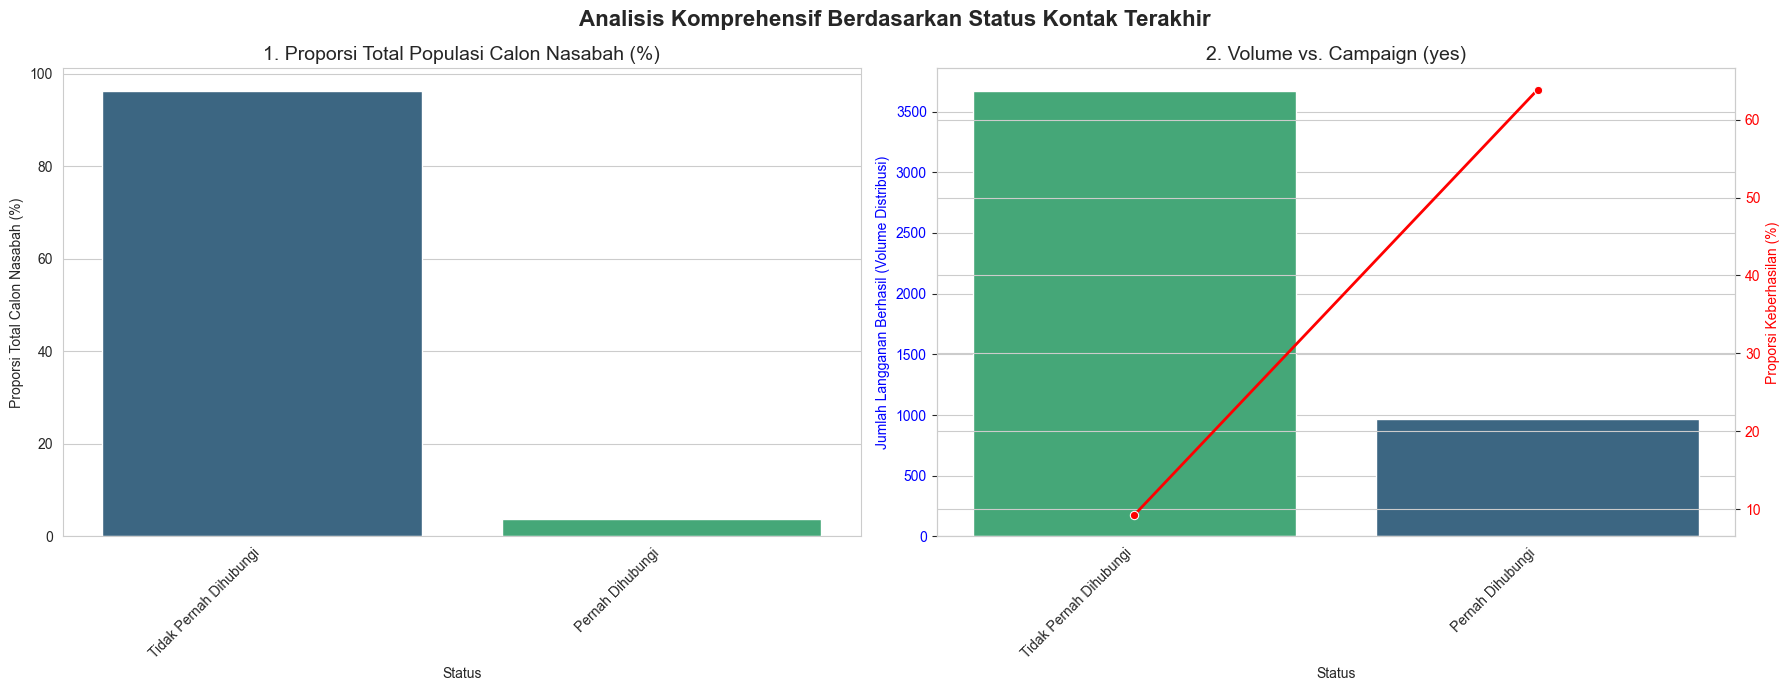

In [183]:
# Urutkan data
pdays_group_proporsi_order = final_merger_pdays_group_sorted.sort_values(by='proporsi %', ascending=False)
pdays_group_order = pdays_group_proporsi_order['pdays_group']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) 

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='pdays_group', y='proporsi %', data=pdays_group_proporsi_order,
    palette='viridis', hue='pdays_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(pdays_group_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='pdays_group', y='distribusi yes', data=final_merger_pdays_group_sorted, order=pdays_group_order,
    ax=ax_vol, palette='viridis', hue='pdays_group', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Status')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(pdays_group_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='pdays_group',
    y='proporsi yes (%)',
    data=final_merger_pdays_group_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Status Kontak Terakhir', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Berdasarkan hasil dari pengelompokkan, client yang pernah dihubungi nilai koefisiennya sampai 60%

**Jumlah kontak yang dilakukan sebelum kampanye saat ini**

In [184]:
# Hitung distribusi sebaran data
previous_distribusi = df_cleaned['previous'].value_counts().reset_index()
previous_distribusi.columns = ['previous', 'distribusi']

# Hitung proporsi data
previous_proporsi = (df_cleaned['previous'].value_counts(normalize=True) *100).reset_index()
previous_proporsi.columns = ['previous', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
previous_distribusi_by_target = pd.crosstab(df_cleaned['previous'], df_cleaned['y']).reset_index()
previous_distribusi_by_target.columns = ['previous', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
previous_proporsi_by_target = (pd.crosstab(df_cleaned['previous'], df_cleaned['y'], normalize='index')*100).reset_index()
previous_proporsi_by_target.columns = ['previous', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : previous_distribusi + previous_proporsi
merger_1 = pd.merge(previous_distribusi, previous_proporsi, how='left', on='previous')

# Merger 2 : merger_1 + previous_distribusi_by_target (mengambil hanya 'jumlah nasabah yang pernah dibuhungi dengan interaksi cenderung positif' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    previous_distribusi_by_target[['previous', 'distribusi yes']], # Hanya ambil kolom 'previous' dan 'distribusi yes'
    how='left',
    on='previous'
)

# Merger 3 : merger_2 + previous_proporsi_by_target (mengambil hanya 'jumlah nasabah yang pernah dibuhungi dengan interaksi cenderung positif' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    previous_proporsi_by_target[['previous', 'proporsi yes (%)']], # Hanya ambil kolom 'previous' dan 'proporsi yes (%)'
    how='left',
    on='previous'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,previous,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,5,18,0.043715,13,72.222222
1,6,5,0.012143,3,60.000000
2,3,216,0.524577,128,59.259259
3,4,70,0.170002,38,54.285714
4,2,754,1.831164,350,46.419098
5,1,4561,11.076841,967,21.201491
6,0,35551,86.339130,3140,8.832382
7,7,1,0.002429,0,0.000000


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1829214596.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(previous_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1829214596.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(previous_order, rotation=45, ha='right')


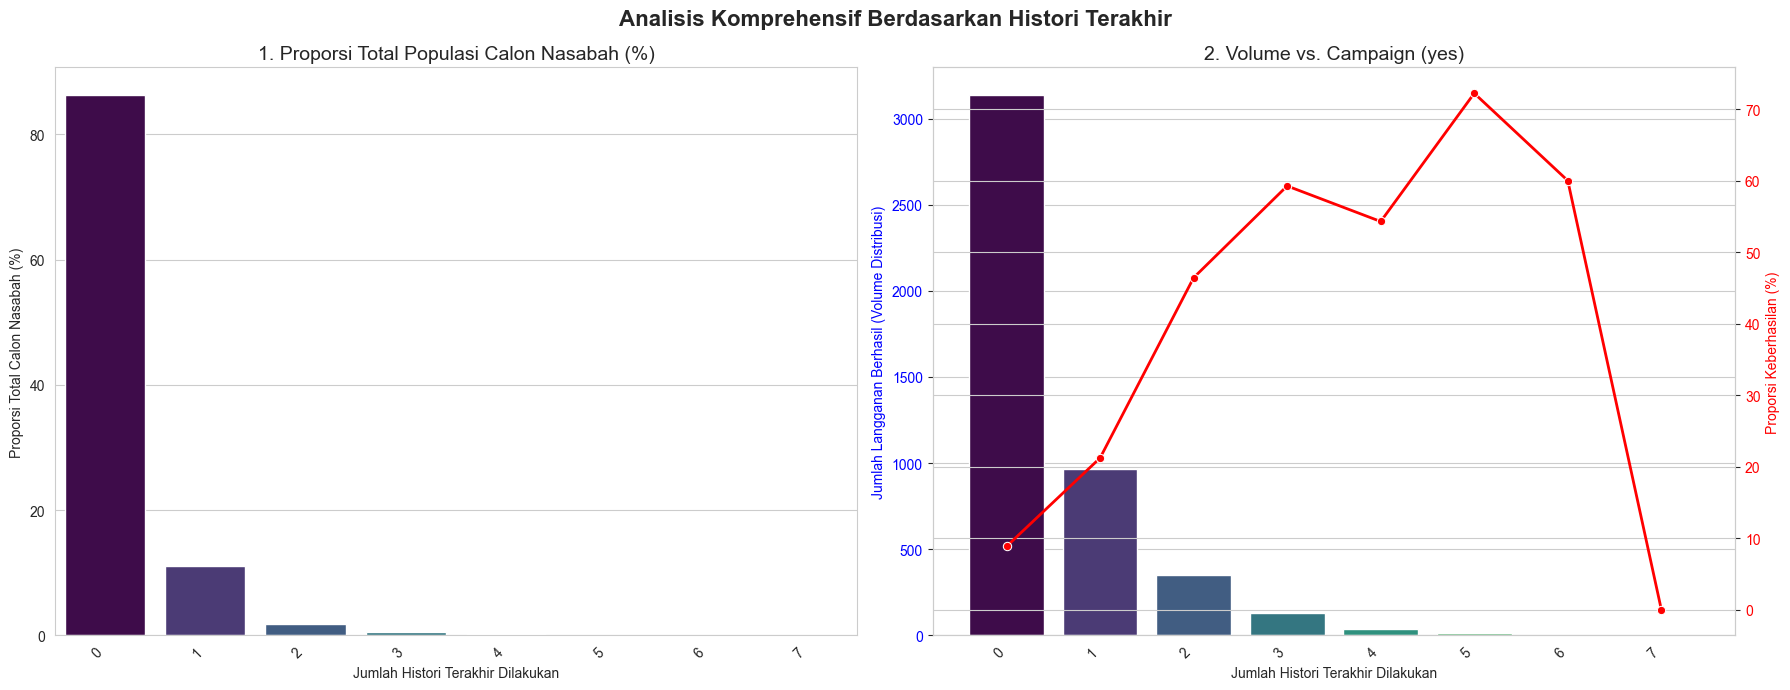

In [185]:
# Urutkan data
previous_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
previous_order = previous_proporsi_order['previous']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='previous', y='proporsi %', data=previous_proporsi_order,
    palette='viridis', hue='previous', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Jumlah Histori Terakhir Dilakukan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(previous_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='previous', y='distribusi yes', data=final_merger_sorted, order=previous_order,
    ax=ax_vol, palette='viridis', hue='previous', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Jumlah Histori Terakhir Dilakukan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(previous_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='previous',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Histori Terakhir', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Terlihat hubungan positif yang sangat kuat antara jumlah kontak sebelumnya (previous) dan keberhasilan kampanye: semakin sering seseorang dihubungi dalam kampanye sebelumnya, semakin besar kemungkinan mereka berlangganan deposito.

Dari 8.8% (tidak pernah dihubungi) naik menjadi >70% pada nasabah yang sudah dihubungi 5 kali.

Artinya, retargeting sangat efektif pelanggan yang sudah memiliki engagement history cenderung lebih percaya dan akhirnya tertarik

**Hasil dari kampanye pemasaran sebelumnya**

In [186]:
# Hitung distribusi sebaran data
poutcome_distribusi = df_cleaned['poutcome'].value_counts().reset_index()
poutcome_distribusi.columns = ['poutcome', 'distribusi']

# Hitung proporsi data
poutcome_proporsi = (df_cleaned['poutcome'].value_counts(normalize=True) *100).reset_index()
poutcome_proporsi.columns = ['poutcome', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
poutcome_distribusi_by_target = pd.crosstab(df_cleaned['poutcome'], df_cleaned['y']).reset_index()
poutcome_distribusi_by_target.columns = ['poutcome', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
poutcome_proporsi_by_target = (pd.crosstab(df_cleaned['poutcome'], df_cleaned['y'], normalize='index')*100).reset_index()
poutcome_proporsi_by_target.columns = ['poutcome', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : poutcome_distribusi + poutcome_proporsi
merger_1 = pd.merge(poutcome_distribusi, poutcome_proporsi, how='left', on='poutcome')

# Merger 2 : merger_1 + poutcome_distribusi_by_target (mengambil hanya 'Hasil Campaign Sebelumnya' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    poutcome_distribusi_by_target[['poutcome', 'distribusi yes']], # Hanya ambil kolom 'poutcome' dan 'distribusi yes'
    how='left',
    on='poutcome'
)

# Merger 3 : merger_2 + poutcome_proporsi_by_target (mengambil hanya 'Hasil Campaign Sebelumnya' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    poutcome_proporsi_by_target[['poutcome', 'proporsi yes (%)']], # Hanya ambil kolom 'poutcome' dan 'proporsi yes (%)'
    how='left',
    on='poutcome'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,poutcome,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,success,1373,3.334467,894,65.112891
1,failure,4252,10.326404,605,14.228598
2,nonexistent,35551,86.339130,3140,8.832382


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3462799784.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(poutcome_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3462799784.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(poutcome_order, rotation=45, ha='right')


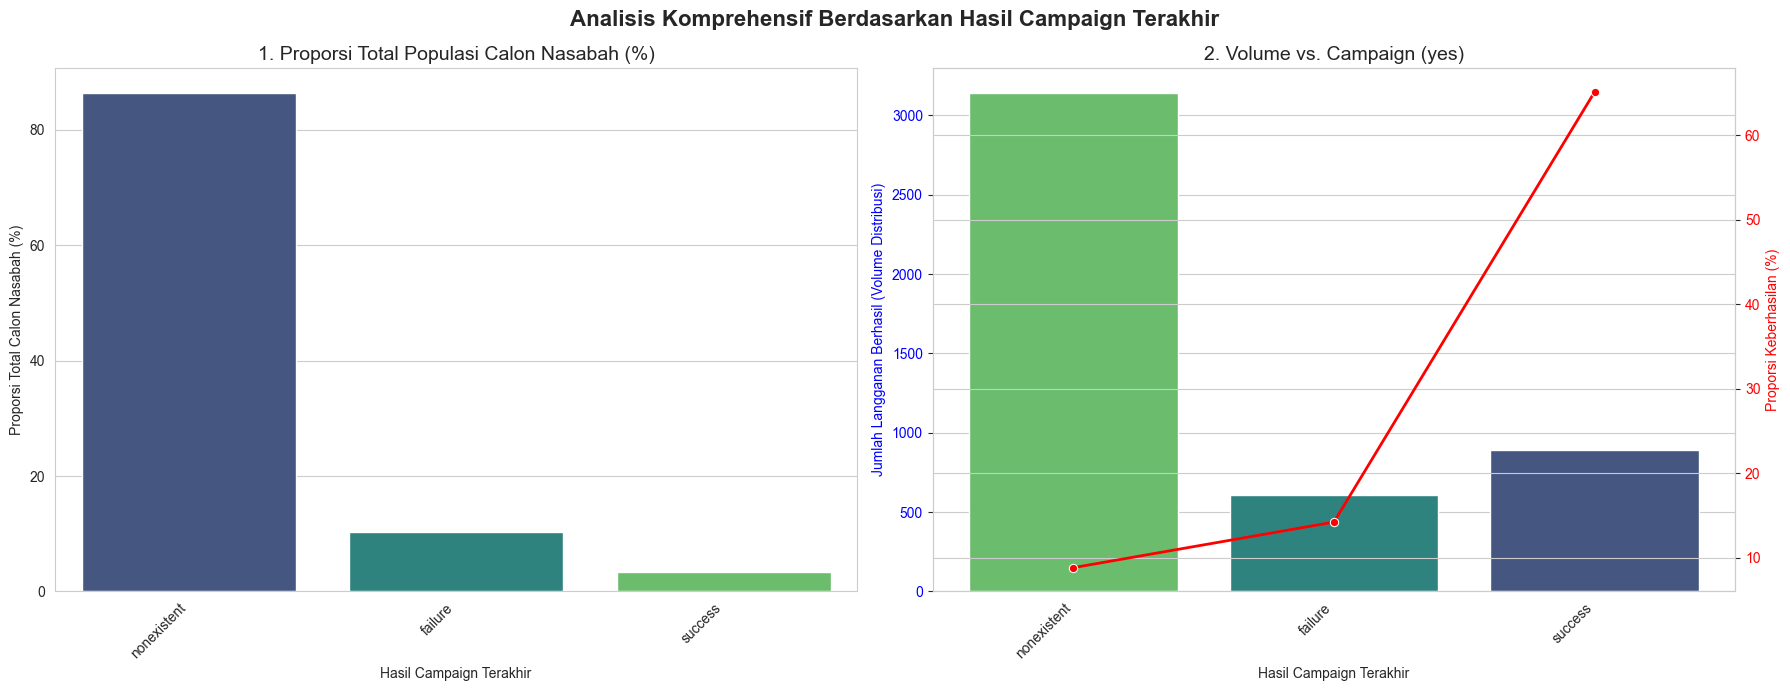

In [187]:
# Urutkan data
poutcome_proporsi_order = final_merger_sorted.sort_values(by='proporsi %', ascending=False)
poutcome_order = poutcome_proporsi_order['poutcome']

# SETUP Figure dan Axes
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 baris, 2 kolom

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='poutcome', y='proporsi %', data=poutcome_proporsi_order,
    palette='viridis', hue='poutcome', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Hasil Campaign Terakhir')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(poutcome_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='poutcome', y='distribusi yes', data=final_merger_sorted, order=poutcome_order,
    ax=ax_vol, palette='viridis', hue='poutcome', legend=False
)
ax_vol.set_title('2. Volume vs. Campaign (yes)', fontsize=14)
ax_vol.set_xlabel('Hasil Campaign Terakhir')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(poutcome_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='poutcome',
    y='proporsi yes (%)',
    data=final_merger_sorted,
    ax=ax_eff,
    color='red',
    marker='o',
    linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Hasil Campaign Terakhir', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

- Klien dengan riwayat keberhasilan memiliki tingkat konversi $\mathbf{65.11\%}$, menjadikannya faktor tunggal terkuat yang mendorong konversi.
- Kelompok nonexistent menyerap 86% kontak ( secara populasi ), namun memberikan efisiensi yang paling rendah ($\mathbf{8.83\%}$). Ini adalah sumber utama inefisiensi anggaran pemasaran bank

### 1.4 Indikator Ekonomi Makro

**Tingkat variasi lapangan kerja**

In [188]:
# Membuat variabel emp_var_rate_group baru
df_cleaned['emp.var.rate_group'] = np.select(
    [
        df_cleaned['emp.var.rate'] < 0,
        df_cleaned['emp.var.rate'] == 0,
        df_cleaned['emp.var.rate'] > 0
    ],
    [
        'Negatif (Membaik)',
        'Nol (Stabil)',
        'Positif (Memburuk)'
    ],
    default='Lainnya'
)

# Ganti nama variabel kolom untuk emp.var.rate_group
group_col = 'emp.var.rate_group'

# Hitung distribusi sebaran data
emp_distribusi = df_cleaned[group_col].value_counts().reset_index()
emp_distribusi.columns = [group_col, 'distribusi']

# Hitung proporsi data
emp_proporsi = (df_cleaned[group_col].value_counts(normalize=True) * 100).reset_index()
emp_proporsi.columns = [group_col, 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
emp_distribusi_by_target = pd.crosstab(df_cleaned[group_col], df_cleaned['y']).reset_index()
emp_distribusi_by_target.columns = [group_col, 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
emp_proporsi_by_target = (pd.crosstab(df_cleaned[group_col], df_cleaned['y'], normalize='index') * 100).reset_index()
emp_proporsi_by_target.columns = [group_col, 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : emp_distribusi + emp_proporsi
merger_1 = pd.merge(emp_distribusi, emp_proporsi, how='left', on=group_col)

# Merger 2 : merger_1 + emp_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    emp_distribusi_by_target[[group_col, 'distribusi yes']],
    how='left',
    on=group_col
)

# Merger 3 : merger_2 + emp_proporsi_by_target
final_merger_emp = pd.merge(
    merger_2,
    emp_proporsi_by_target[[group_col, 'proporsi yes (%)']],
    how='left',
    on=group_col
)

# Sort hasil merger berdasarkan Efisiensi (proporsi yes %)
final_merger_emp_sorted = final_merger_emp.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)

final_merger_emp_sorted

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1590391453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['emp.var.rate_group'] = np.select(


,emp.var.rate_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,Negatif (Membaik),17186,41.737906,3533,20.557430
1,Positif (Memburuk),23990,58.262094,1106,4.610254


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1526792717.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(emp_group_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1526792717.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(emp_group_order, rotation=45, ha='right')


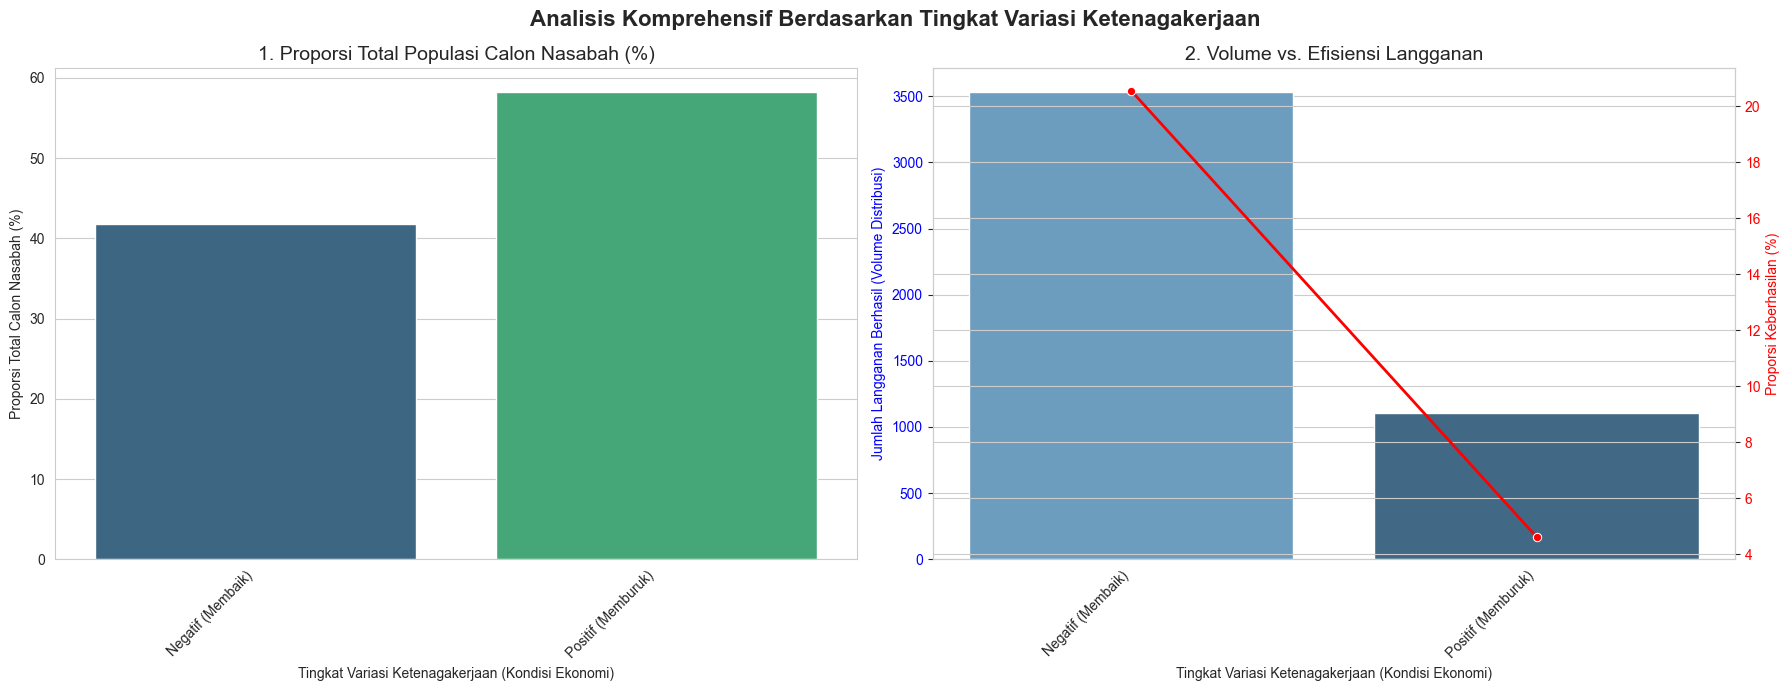

In [189]:
# Ambil urutan kategori baru
emp_group_order = final_merger_emp_sorted['emp.var.rate_group']

# SETUP Figure dan Axis
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='emp.var.rate_group', y='proporsi %', data=final_merger_emp_sorted,
    order=emp_group_order, palette='viridis', hue='emp.var.rate_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Tingkat Variasi Ketenagakerjaan (Kondisi Ekonomi)')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(emp_group_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='emp.var.rate_group', y='distribusi yes', data=final_merger_emp_sorted, order=emp_group_order,
    ax=ax_vol, palette='Blues_d', hue='emp.var.rate_group', legend=False
)
ax_vol.set_title('2. Volume vs. Efisiensi Langganan', fontsize=14)
ax_vol.set_xlabel('Tingkat Variasi Ketenagakerjaan (Kondisi Ekonomi)')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(emp_group_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='emp.var.rate_group', y='proporsi yes (%)', data=final_merger_emp_sorted,
    ax=ax_eff, color='red', marker='o', linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Tingkat Variasi Ketenagakerjaan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Makna emp.var.rate:
Variabel ini menggambarkan tingkat perubahan lapangan kerja (employment variation rate).

Nilai negatif berarti pengangguran menurun / ekonomi membaik.

Nilai positif berarti pengangguran meningkat / ekonomi memburuk.

Korelasi dengan Keputusan Deposito:

Saat emp.var.rate negatif (ekonomi membaik) → tingkat kepercayaan diri finansial meningkat, nasabah merasa aman menempatkan dana jangka panjang → konversi naik signifikan (20.6%).

Saat emp.var.rate positif (ekonomi memburuk) → nasabah cenderung likuid (pegang uang tunai), menunda investasi → konversi anjlok (4.6%).


**Indeks harga konsumen**

In [190]:
bins = [92.0, 93.0, 94.0, 95.0] 
labels = ['Rendah (<93.0)', 'Sedang (93.0-94.0)', 'Tinggi (>94.0)']

# Membuat variabel cons_price_group baru
df_cleaned['cons.price.idx_group'] = pd.cut(
    df_cleaned['cons.price.idx'], 
    bins=bins, 
    labels=labels, 
    right=False, # Interval inklusif di batas bawah
    include_lowest=True # Memastikan nilai minimum disertakan
)

# Ganti nama variabel kolom untuk cons.price.idx_group
group_col = 'cons.price.idx_group'

# Hitung distribusi sebaran data
cpi_distribusi = df_cleaned[group_col].value_counts().reset_index()
cpi_distribusi.columns = [group_col, 'distribusi']

# Hitung proporsi data
cpi_proporsi = (df_cleaned[group_col].value_counts(normalize=True) * 100).reset_index()
cpi_proporsi.columns = [group_col, 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
cpi_distribusi_by_target = pd.crosstab(df_cleaned[group_col], df_cleaned['y']).reset_index()
cpi_distribusi_by_target.columns = [group_col, 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
cpi_proporsi_by_target = (pd.crosstab(df_cleaned[group_col], df_cleaned['y'], normalize='index') * 100).reset_index()
cpi_proporsi_by_target.columns = [group_col, 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : cpi_distribusi + cpi_proporsi
merger_1 = pd.merge(cpi_distribusi, cpi_proporsi, how='left', on=group_col)

# Merger 2 : merger_1 + cpi_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    cpi_distribusi_by_target[[group_col, 'distribusi yes']],
    how='left',
    on=group_col
)

# Merger 3 : merger_2 + cpi_proporsi_by_target
final_merger_cpi = pd.merge(
    merger_2,
    cpi_proporsi_by_target[[group_col, 'proporsi yes (%)']],
    how='left',
    on=group_col
)

# Sort hasil merger berdasarkan Efisiensi (proporsi yes %)
final_merger_cpi_sorted = final_merger_cpi.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_cpi_sorted

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\4265711007.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cons.price.idx_group'] = pd.cut(


,cons.price.idx_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,Rendah (<93.0),8989,21.830678,1786,19.868728
1,Tinggi (>94.0),5782,14.042160,892,15.427188
2,Sedang (93.0-94.0),26405,64.127161,1961,7.426624


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3422421009.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(cpi_group_order, rotation=0, ha='center')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3422421009.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(cpi_group_order, rotation=0, ha='center')


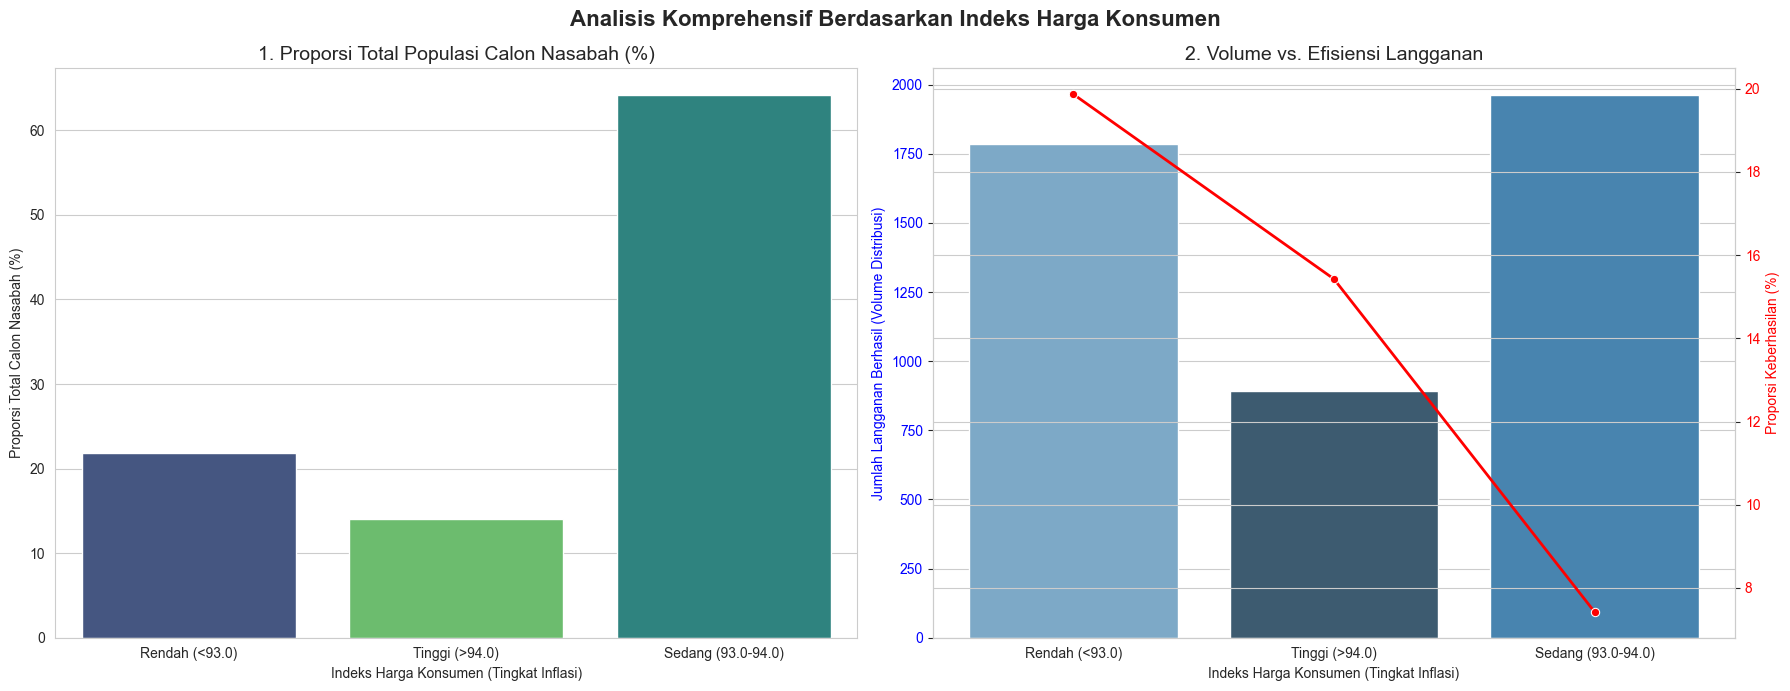

In [191]:
# Ambil urutan kategori baru
cpi_group_order = final_merger_cpi_sorted['cons.price.idx_group'].tolist()

# SETUP Figure dan Axis
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='cons.price.idx_group', y='proporsi %', data=final_merger_cpi_sorted,
    order=cpi_group_order, palette='viridis', hue='cons.price.idx_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Indeks Harga Konsumen (Tingkat Inflasi)')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(cpi_group_order, rotation=0, ha='center')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='cons.price.idx_group', y='distribusi yes', data=final_merger_cpi_sorted, order=cpi_group_order,
    ax=ax_vol, palette='Blues_d', hue='cons.price.idx_group', legend=False
)
ax_vol.set_title('2. Volume vs. Efisiensi Langganan', fontsize=14)
ax_vol.set_xlabel('Indeks Harga Konsumen (Tingkat Inflasi)')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(cpi_group_order, rotation=0, ha='center')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='cons.price.idx_group', y='proporsi yes (%)', data=final_merger_cpi_sorted,
    ax=ax_eff, color='red', marker='o', linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Indeks Harga Konsumen', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Makna CPI (Consumer Price Index):

Mencerminkan tingkat inflasi: semakin tinggi CPI, semakin tinggi harga barang dan jasa.

CPI rendah berarti inflasi rendah → kondisi ekonomi relatif stabil.

Korelasi dengan Keputusan Deposito (Proporsi Yes):

Inflasi rendah (CPI < 93) → konversi tinggi (19.9%)
Artinya masyarakat lebih percaya terhadap stabilitas ekonomi, sehingga berani mengunci uang dalam deposito.

Inflasi tinggi (CPI > 94) → konversi masih cukup tinggi (15.4%)
Ini agak anomali, karena secara teori inflasi tinggi biasanya menurunkan minat deposito (karena nilai uang tergerus).
Tapi di sini, inflasi tinggi justru bisa memicu flight to safety: orang menghindari konsumsi dan mencari aset aman seperti deposito.

Inflasi sedang (93–94) → konversi justru terendah (7.4%)
Ini menarik: periode ini tampak seperti masa ketidakpastian — inflasi belum rendah tapi juga belum cukup tinggi untuk memicu reaksi “save more”.
Nasabah mungkin menunggu arah ekonomi (uncertainty zone).

**Indeks kepercayaan konsumen**

In [192]:
bins = [-60.0, -40.0, -35.0, -25.0] 
labels = ['Pesimis Tinggi (<-40.0)', 'Netral/Sedang (-40.0 hingga -35.0)', 'Optimis Relatif (>-35.0)']

# Membuat variabel cons.conf.idx_group baru
df_cleaned['cci_group'] = pd.cut(
    df_cleaned['cons.conf.idx'], 
    bins=bins, 
    labels=labels, 
    right=False, # Interval inklusif di batas bawah
    include_lowest=True 
)

# Ganti nama variabel kolom untuk cci_group
group_col = 'cci_group'

# Hitung distribusi sebaran data
cci_distribusi = df_cleaned[group_col].value_counts().reset_index()
cci_distribusi.columns = [group_col, 'distribusi']

# Hitung proporsi data
cci_proporsi = (df_cleaned[group_col].value_counts(normalize=True) * 100).reset_index()
cci_proporsi.columns = [group_col, 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
cci_distribusi_by_target = pd.crosstab(df_cleaned[group_col], df_cleaned['y']).reset_index()
cci_distribusi_by_target.columns = [group_col, 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
cci_proporsi_by_target = (pd.crosstab(df_cleaned[group_col], df_cleaned['y'], normalize='index') * 100).reset_index()
cci_proporsi_by_target.columns = [group_col, 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : cci_distribusi + cci_proporsi
merger_1 = pd.merge(cci_distribusi, cci_proporsi, how='left', on=group_col)

# Merger 2 : merger_1 + cci_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    cci_distribusi_by_target[[group_col, 'distribusi yes']],
    how='left',
    on=group_col
)

# Merger 3 : merger_2 + cci_proporsi_by_target
final_merger_cci = pd.merge(
    merger_2,
    cci_proporsi_by_target[[group_col, 'proporsi yes (%)']],
    how='left',
    on=group_col
)

# Sort hasil merger berdasarkan Efisiensi (proporsi yes %)
final_merger_cci_sorted = final_merger_cci.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_cci_sorted

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\2965377407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cci_group'] = pd.cut(


,cci_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,Optimis Relatif (>-35.0),2627,6.379930,1118,42.558051
1,Pesimis Tinggi (<-40.0),24637,59.833398,2511,10.191988
2,Netral/Sedang (-40.0 hingga -35.0),13912,33.786672,1010,7.259919


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1410356932.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(cci_group_order, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1410356932.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(cci_group_order, rotation=45, ha='right')


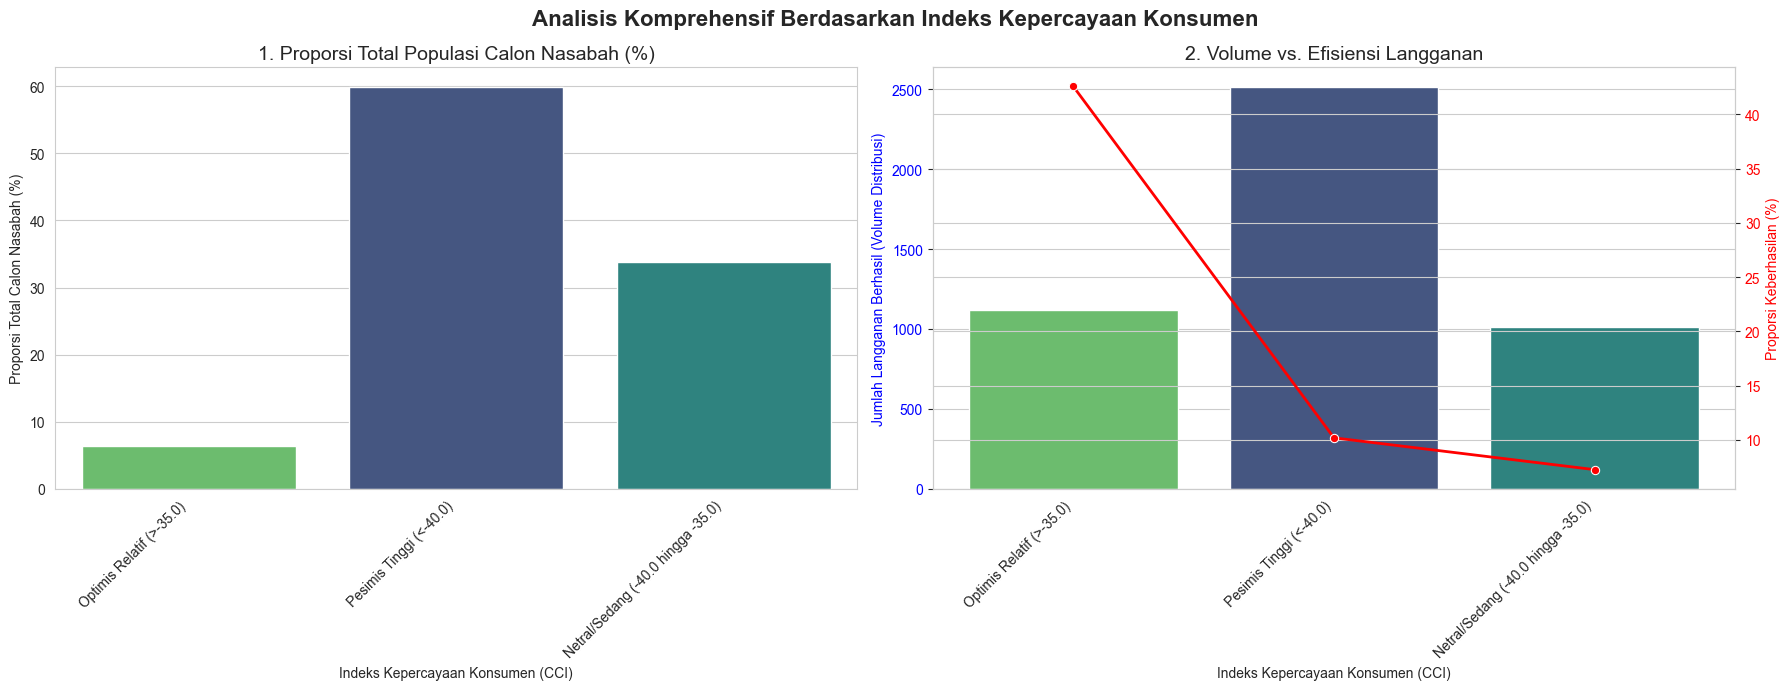

In [193]:
# Ambil urutan kategori baru
cci_group_order = final_merger_cci_sorted['cci_group'].tolist()

# SETUP Figure dan Axis
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='cci_group', y='proporsi %', data=final_merger_cci_sorted,
    order=cci_group_order, palette='viridis', hue='cci_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Indeks Kepercayaan Konsumen (CCI)')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(cci_group_order, rotation=45, ha='right')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='cci_group', y='distribusi yes', data=final_merger_cci_sorted, order=cci_group_order,
    ax=ax_vol, palette='viridis', hue='cci_group', legend=False
)
ax_vol.set_title('2. Volume vs. Efisiensi Langganan', fontsize=14)
ax_vol.set_xlabel('Indeks Kepercayaan Konsumen (CCI)')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(cci_group_order, rotation=45, ha='right')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='cci_group', y='proporsi yes (%)', data=final_merger_cci_sorted,
    ax=ax_eff, color='red', marker='o', linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Indeks Kepercayaan Konsumen', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

Makna CCI:

Semakin tinggi nilai CCI (lebih mendekati nol atau positif), masyarakat lebih percaya diri terhadap kondisi ekonomi & pekerjaan.

Semakin rendah (negatif besar), menandakan pesimisme tinggi masyarakat takut kehilangan pekerjaan, penghasilan, atau daya beli.

Korelasi dengan Proporsi Yes (Minat Deposito):

Optimis Relatif (>-35) → konversi tertinggi: 42.56%
Ini luar biasa tinggi, artinya ketika kepercayaan konsumen naik, keputusan untuk menabung jangka panjang meningkat tajam.

Netral (-40 s.d -35) → konversi rendah: 7.26%
Sikap ragu-ragu membuat nasabah menunda keputusan finansial besar, termasuk deposito.

Pesimis Tinggi (<-40) → konversi sedang: 10.19%
Walau pesimis, ada sebagian yang justru berlindung pada produk aman seperti deposito (flight to safety).

**Suku bunga Euribor 3-bulan**

In [194]:
bins = [0.0, 1.5, 4.5, 6.0] 
labels = ['Rendah (<1.5)', 'Sedang (1.5-4.5)', 'Tinggi (>4.5)']

# Membuat variabel euribor_group baru
df_cleaned['euribor_group'] = pd.cut(
    df_cleaned['euribor3m'], 
    bins=bins, 
    labels=labels, 
    right=False, # Interval inklusif di batas bawah
    include_lowest=True 
)

# Ganti nama variabel kolom untuk euribor_group
group_col = 'euribor_group'

# Hitung distribusi sebaran data
euribor_distribusi = df_cleaned[group_col].value_counts().reset_index()
euribor_distribusi.columns = [group_col, 'distribusi']

# Hitung proporsi data
euribor_proporsi = (df_cleaned[group_col].value_counts(normalize=True) * 100).reset_index()
euribor_proporsi.columns = [group_col, 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
euribor_distribusi_by_target = pd.crosstab(df_cleaned[group_col], df_cleaned['y']).reset_index()
euribor_distribusi_by_target.columns = [group_col, 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
euribor_proporsi_by_target = (pd.crosstab(df_cleaned[group_col], df_cleaned['y'], normalize='index') * 100).reset_index()
euribor_proporsi_by_target.columns = [group_col, 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : euribor_distribusi + euribor_proporsi
merger_1 = pd.merge(euribor_distribusi, euribor_proporsi, how='left', on=group_col)

# Merger 2 : merger_1 + euribor_distribusi_by_target
merger_2 = pd.merge(
    merger_1,
    euribor_distribusi_by_target[[group_col, 'distribusi yes']],
    how='left',
    on=group_col
)

# Merger 3 : merger_2 + euribor_proporsi_by_target
final_merger_euribor = pd.merge(
    merger_2,
    euribor_proporsi_by_target[[group_col, 'proporsi yes (%)']],
    how='left',
    on=group_col
)

# Sort hasil merger berdasarkan Efisiensi (proporsi yes %)
final_merger_euribor_sorted = final_merger_euribor.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_euribor_sorted

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1253354760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['euribor_group'] = pd.cut(


,euribor_group,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,Rendah (<1.5),13212,32.086652,3174,24.023615
1,Sedang (1.5-4.5),3884,9.432679,308,7.929969
2,Tinggi (>4.5),24080,58.480668,1157,4.804817


C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3153098176.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(euribor_group_order, rotation=0, ha='center')
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3153098176.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_vol.set_xticklabels(euribor_group_order, rotation=0, ha='center')


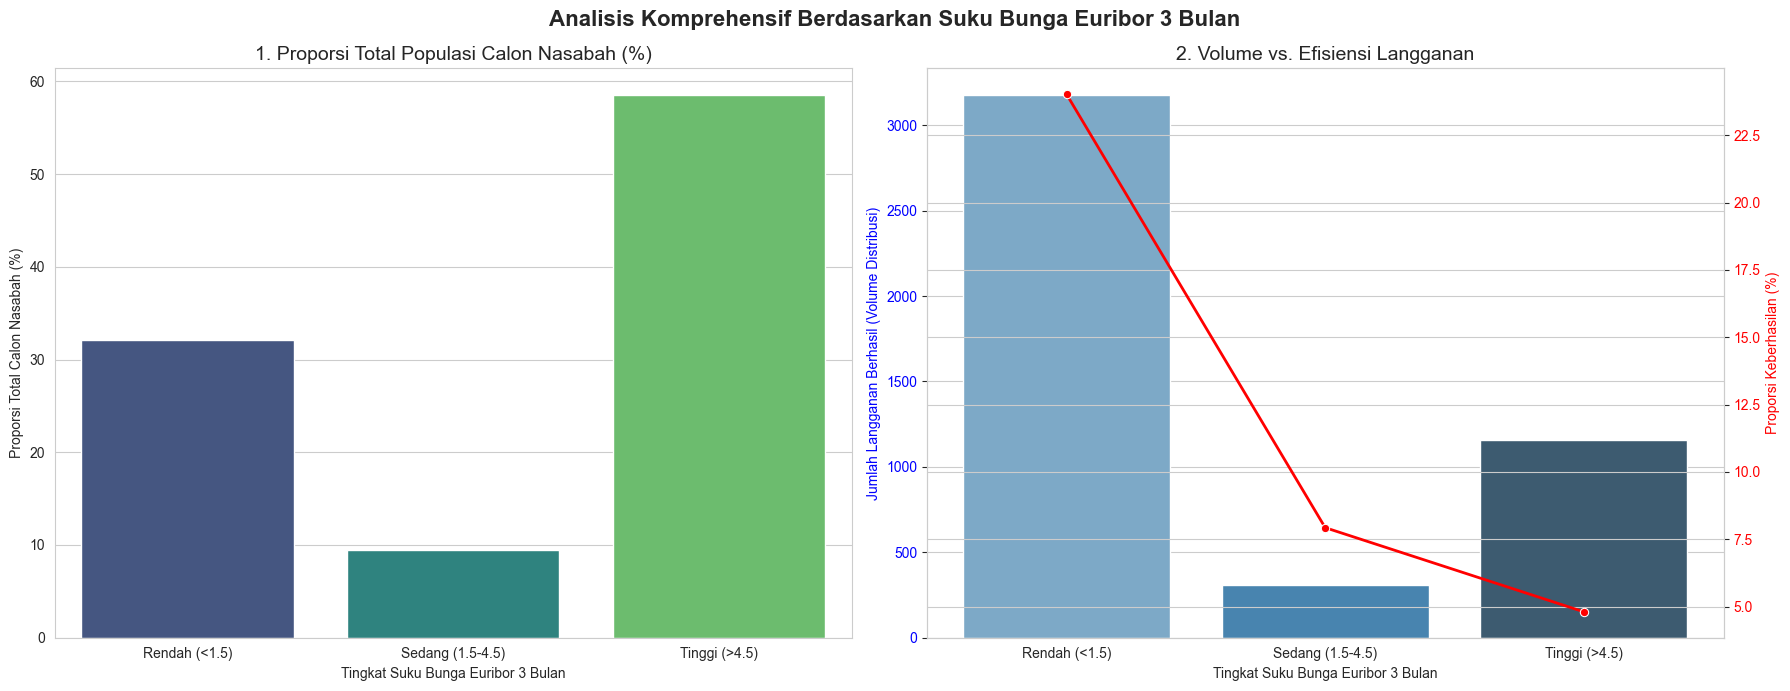

In [195]:
# Ambil urutan kategori baru
euribor_group_order = final_merger_euribor_sorted['euribor_group'].tolist()

# SETUP Figure dan Axis
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot kiri : Proporsi Total Populasi
sns.barplot(
    x='euribor_group', y='proporsi %', data=final_merger_euribor_sorted,
    order=euribor_group_order, palette='viridis', hue='euribor_group', legend=False, ax=axes[0]
)
axes[0].set_title('1. Proporsi Total Populasi Calon Nasabah (%)', fontsize=14)
axes[0].set_xlabel('Tingkat Suku Bunga Euribor 3 Bulan')
axes[0].set_ylabel('Proporsi Total Calon Nasabah (%)')
axes[0].set_xticklabels(euribor_group_order, rotation=0, ha='center')

# Plot kanan : Dual Axis (By Target Variable)
ax_vol = axes[1]
ax_eff = ax_vol.twinx()

# 1. Bar Plot (Volume Keberhasilan)
sns.barplot(
    x='euribor_group', y='distribusi yes', data=final_merger_euribor_sorted, order=euribor_group_order,
    ax=ax_vol, palette='Blues_d', hue='euribor_group', legend=False
)
ax_vol.set_title('2. Volume vs. Efisiensi Langganan', fontsize=14)
ax_vol.set_xlabel('Tingkat Suku Bunga Euribor 3 Bulan')
ax_vol.set_ylabel('Jumlah Langganan Berhasil (Volume Distribusi)', color='blue')
ax_vol.tick_params(axis='y', labelcolor='blue')
ax_vol.set_xticklabels(euribor_group_order, rotation=0, ha='center')

# 2. Line Plot (Proporsi Keberhasilan )
sns.lineplot(
    x='euribor_group', y='proporsi yes (%)', data=final_merger_euribor_sorted,
    ax=ax_eff, color='red', marker='o', linewidth=2
)
ax_eff.set_ylabel('Proporsi Keberhasilan (%)', color='red')
ax_eff.tick_params(axis='y', labelcolor='red')

# Tamplikan plot
plt.suptitle('Analisis Komprehensif Berdasarkan Suku Bunga Euribor 3 Bulan', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

- Data menunjukkan korelasi negatif, periode Suku Bunga Rendah adalah yang paling efisien (24%), membantah hipotesa awal yaitu "Periode dengan suku bunga Euribor 3 bulan (euribor3m) tinggi akan berkorelasi positif secara signifikan dengan tingkat konversi kampanye."
- Secara mayoritas populasi (58%), calon nasabah di hubungi pada saat bunga bank lagi tinggi tetapi konversi yesnya malah paling rendah di angka 4.8% saja.

**P.S** *Perlu dilakukan tindakan analisa lebih mendalam terkait fenomena anomali ini*


**Index tenaga kerja**

In [217]:
# Hitung distribusi sebaran data
nr_employed_distribusi = df_cleaned['nr.employed'].value_counts().reset_index()
nr_employed_distribusi.columns = ['nr.employed', 'distribusi']

# Hitung proporsi data
nr_employed_proporsi = (df_cleaned['nr.employed'].value_counts(normalize=True) *100).reset_index()
nr_employed_proporsi.columns = ['nr.employed', 'proporsi %']

# Hitung distribusi sebaran data dengan variable target 'y'
nr_employed_distribusi_by_target = pd.crosstab(df_cleaned['nr.employed'], df_cleaned['y']).reset_index()
nr_employed_distribusi_by_target.columns = ['nr.employed', 'distribusi no', 'distribusi yes']

# Hitung Proporsi data dengan variable target 'y'
nr_employed_proporsi_by_target = (pd.crosstab(df_cleaned['nr.employed'], df_cleaned['y'], normalize='index')*100).reset_index()
nr_employed_proporsi_by_target.columns = ['nr.employed', 'proporsi no (%)', 'proporsi yes (%)']

# Merger 1 : nr_employed_distribusi + nr_employed_proporsi
merger_1 = pd.merge(nr_employed_distribusi, nr_employed_proporsi, how='left', on='nr.employed')

# Merger 2 : merger_1 + nr_employed_distribusi_by_target (mengambil hanya 'index tenaga kerja' dan 'distribusi yes')
merger_2 = pd.merge(
    merger_1,
    nr_employed_distribusi_by_target[['nr.employed', 'distribusi yes']], # Hanya ambil kolom 'nr_employed' dan 'distribusi yes'
    how='left',
    on='nr.employed'
)

# Merger 3 : merger_2 + nr_employed_proporsi_by_target (mengambil hanya 'index tenaga kerja' dan 'proporsi yes (%)')
final_merger = pd.merge(
    merger_2,
    nr_employed_proporsi_by_target[['nr.employed', 'proporsi yes (%)']], # Hanya ambil kolom 'nr_employed' dan 'proporsi yes (%)'
    how='left',
    on='nr.employed'
)

# Sort hasil merger
final_merger_sorted = final_merger.sort_values(by='proporsi yes (%)', ascending=False).reset_index(drop=True)
final_merger_sorted

,nr.employed,distribusi,proporsi %,distribusi yes,proporsi yes (%)
0,5008.7,650,1.578589,369,56.769231
1,4991.6,773,1.877307,403,52.134541
2,5023.5,172,0.417719,88,51.162791
3,4963.6,635,1.542160,301,47.401575
4,5017.5,1070,2.598601,454,42.429907
5,5076.2,1662,4.036332,593,35.679904
6,5099.1,8532,20.720808,1092,12.798875
7,5176.3,10,0.024286,1,10.000000
8,5195.8,3682,8.942102,232,6.300923
9,5228.1,16228,39.411308,866,5.336456


## 2. Korelasi

### 2.1 Uji Normalitas (numerik)

**Melakukan uji normalitas dengan Kolmogorov-Smirnov**

In [219]:
# Daftar SEMUA variabel numerik (kecuali Y) yang akan diuji
all_numerical_vars = [
    'age', 'duration', 'campaign', 'pdays', 'previous', 
    'euribor3m', 'emp.var.rate', 'cons.price.idx', 
    'cons.conf.idx', 'nr.employed'
]

print("--- Hasil Uji Normalitas D'Agostino's K-squared Komprehensif ---")

for col in all_numerical_vars:
    # Uji normalitas
    statistic, p_value = stats.normaltest(df[col])
    
    # Interpretasi
    is_normal = "TIDAK NORMAL (P-value <= 0.05)" if p_value <= 0.05 else "NORMAL (P-value > 0.05)"
    
    print(f"Variabel: {col}")
    print(f"  P-value: {p_value:.3e}")
    print(f"  Kesimpulan: {is_normal}")
    print("-" * 30)

--- Hasil Uji Normalitas D'Agostino's K-squared Komprehensif ---
Variabel: age
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: duration
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: campaign
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: pdays
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: previous
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: euribor3m
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: emp.var.rate
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Variabel: cons.price.idx
  P-value: 0.000e+00
  Kesimpulan: TIDAK NORMAL (P-value <= 0.05)
------------------------------
Vari

*Hasil dari uji normalitas, semua kolom numerik bersifat tidak normal. Jadi, diputuskan akan melakukan uji **Non-Parametrik**

### 2.2 Korelasi & Uji

#### Korelasi spearman

**Uji korelasi antara kolom numerik dengan kolom biner**

In [220]:
cols_to_correlate = [
    'age', 'duration', 'campaign', 'pdays', 'previous', 
    'euribor3m', 'emp.var.rate', 'cons.price.idx', 
    'cons.conf.idx', 'nr.employed', 'Y'
]

# Hitung Matriks Korelasi Spearman (menggunakan metode 'spearman')
correlation_matrix_spearman = df_cleaned[cols_to_correlate].corr(method='spearman')

# Fokus pada korelasi dengan variabel target 'Y' dan urutkan
correlation_with_y_spearman = correlation_matrix_spearman['Y'].sort_values(ascending=False)

print("Korelasi Spearman dengan Variabel Target (Y) (Koefisien ρ):\n")
print(correlation_with_y_spearman)

Korelasi Spearman dengan Variabel Target (Y) (Koefisien ρ):

Y                 1.000000
duration          0.348784
previous          0.200933
cons.conf.idx     0.041127
age              -0.011913
campaign         -0.063655
cons.price.idx   -0.122123
emp.var.rate     -0.247427
euribor3m        -0.266772
nr.employed      -0.283912
pdays            -0.324975
Name: Y, dtype: float64


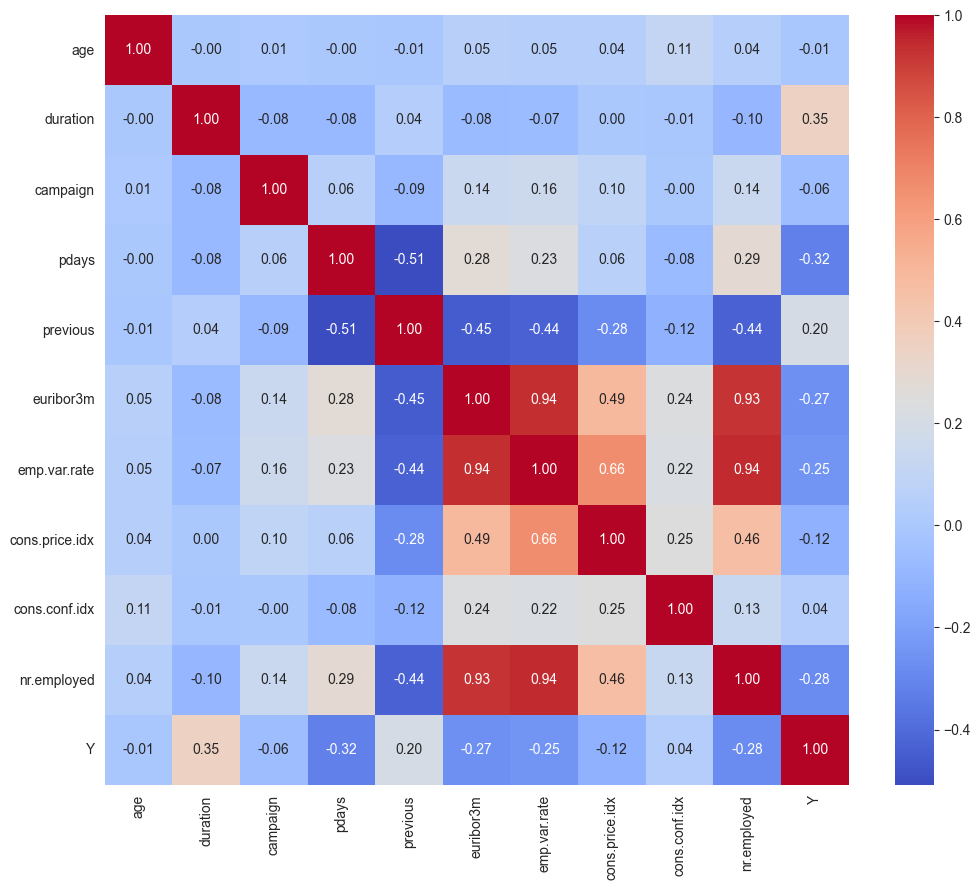

In [221]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_spearman , annot=True, cmap='coolwarm', fmt=".2f")     
plt.show()

Nilai yang mendekati mendekati $\pm 1$, semakin kuat hubungannya.
- ('duration') semakin lama waktu panggilan dilakukan, semakin tinggi juga kemungkinan berhasilnya kampanye ini dilakukan
- ('previous') semakin banyak kontak yang dilakukan sebelum kampanye ini berjalan, semakin tinggi juga kemungkinan berhasilnya kampanye ini dilakukan
- ('cons.conf.idx') indeks kepercayaan konsumen memiliki hubungan yang sangat minim dengan hasil kampanye berhasil
- ('age') umur memiliki hubungan yang sangat minim dengan hasil kampanye
- ('campaign') semakin banyak kontak dilakukan selama kampanye ini, semakin rendah kemungkinan hasil kampanye berhasil
- ('cons.price.idx') semakin tinggi indeks harga konsumen, semakin rendah kemungkinan hasil kampanye berhasil
- ('emp.var.rate') semakin tinggi tingkat variasi pekerjaan, semakin rendah kemungkinan hasil kampanye berhasil
- ('euribor3m') semakin tinggi suku bunga yang ditawarkan, semakin rendah juga kemungkinan hasil kampanye berhasil
- ('nr.employed') semakin tinggi jumlah karyawan, semakin rendah juga hasil kampanye berhasil
- ('pdays') semakin banyak hari berlalu setelah kontak terakhir, semakin rendah kemungkinan hasil kampanye berhasil.

#### Uji Chi-Square

**Apakah jenis pekerjaan mempengaruhi hasil dari kampanye?**

In [222]:
# Jenis pekerjaan 
cross_tab_job = pd.crosstab(df_cleaned['job'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_job)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}")



Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 961.744
P-value (p): 0.0000
Degrees of Freedom (dof): 11
Frekuensi Harapan (expected):
[[9245.17 1173.83]
 [8210.53 1042.47]
 [1291.96  164.04]
 [ 940.58  119.42]
 [2594.57  329.43]
 [1524.45  193.55]
 [1260.91  160.09]
 [3520.07  446.93]
 [ 776.42   98.58]
 [5979.77  759.23]
 [ 899.76  114.24]
 [ 292.82   37.18]]


Dari hasil pengujian, Terdapat hubungan yang signifikan secara statistik antara jenis pekerjaan klien dan hasil dari kampanye pemasaran bank. Yang mana, jenis pekerjaan memang mempengaruhi hasil dari kampanye yang dilakukan.

**Apakah bulan mempengaruhi hasil dari kampanye?**

In [223]:
# Efek Musiman (month)
cross_tab_month = pd.crosstab(df_cleaned['month'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_month)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}")




Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 3103.033
P-value (p): 0.0000
Degrees of Freedom (dof): 9
Frekuensi Harapan (expected):
[[ 2334.58   296.42]
 [ 5480.2    695.8 ]
 [  161.5     20.5 ]
 [ 6361.32   807.68]
 [ 4718.86   599.14]
 [  484.49    61.51]
 [12215.97  1551.03]
 [ 3638.08   461.92]
 [  636.22    80.78]
 [  505.78    64.22]]


Dari hasil pengujian, Terdapat hubungan yang signifikan secara statistik antara bulan dan hasil dari kampanye pemasaran bank. Yang mana, bulan memang mempengaruhi hasil dari kampanye yang dilakukan.

**Apakah hasil kampanye sebelumnya mempengaruhi hasil kampanye saat ini?**

In [224]:
# Hasil kampanye sebelumnya 
cross_tab_poutcome = pd.crosstab(df_cleaned['poutcome'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_poutcome)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 



Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 4230.143
P-value (p): 0.0000
Degrees of Freedom (dof): 2
Frekuensi Harapan (expected):
[[ 3772.96   479.04]
 [31545.73  4005.27]
 [ 1218.31   154.69]]


Dari hasil pengujian, Terdapat hubungan yang signifikan secara statistik antara hasil dari kampanye sebelumnya dan hasil dari kampanye pemasaran saat ini. Yang mana, hasil dari kampanye sebelumnya memang mempengaruhi hasil dari kampanye yang dilakukan saat ini.

**Apakah status kredit mempengaruhi hasil kampanye?**

In [225]:
# Status kredit
cross_tab_default = pd.crosstab(df_cleaned['default'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_default)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 406.556
P-value (p): 0.0000
Degrees of Freedom (dof): 2
Frekuensi Harapan (expected):
[[2.890679e+04 3.670210e+03]
 [7.627550e+03 9.684500e+02]
 [2.660000e+00 3.400000e-01]]


Dari hasil pengujian, Terdapat hubungan yang signifikan secara statistik antara status kredit calon nasabah dan hasil dari kampanye pemasaran saat ini. Yang mana, status kredit calon nasabah memang mempengaruhi hasil dari kampanye yang dilakukan saat ini

**Apakah durasi panggilan mempengaruhi keberhasilan kampanye?**

In [226]:
# Durasi panggilan
cross_tab_duration_stage = pd.crosstab(df_cleaned['duration_stage'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_duration_stage)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 7128.458
P-value (p): 0.0000
Degrees of Freedom (dof): 5
Frekuensi Harapan (expected):
[[ 8766.01  1112.99]
 [11325.97  1438.03]
 [10057.08  1276.92]
 [ 3301.78   419.22]
 [ 2233.43   283.57]
 [  852.73   108.27]]


Dari hasil pengujian, Terdapat hubungan yang signifikan secara statistik antara lamanya panggilan dilakukan dan hasil dari kampanye pemasaran saat ini. Yang mana, lamanya durasi panggilan memang mempengaruhi hasil dari kampanye yang dilakukan saat ini.

**Apakah Status pernikahan mempengaruhi keberhasilan kampanye?**

In [227]:
# Status Pernikahan
cross_tab_marital = pd.crosstab(df_cleaned['marital'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_marital)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 122.959
P-value (p): 0.0000
Degrees of Freedom (dof): 3
Frekuensi Harapan (expected):
[[4.091510e+03 5.194900e+02]
 [2.211333e+04 2.807670e+03]
 [1.026117e+04 1.302830e+03]
 [7.099000e+01 9.010000e+00]]


Dari hasil pengujian, terdapat hasil bahwa status pernikahan mempengaruhi hasil dari kampanye yang berlangsung

**Apakah tingkat pendidikan mempengaruhi keberhasilan kampanye?**

In [228]:
# Tingkat Pendidikan
cross_tab_education = pd.crosstab(df_cleaned['education'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_education)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 192.849
P-value (p): 0.0000
Degrees of Freedom (dof): 7
Frekuensi Harapan (expected):
[[3.705520e+03 4.704800e+02]
 [2.032890e+03 2.581100e+02]
 [5.363950e+03 6.810500e+02]
 [8.440350e+03 1.071650e+03]
 [1.597000e+01 2.030000e+00]
 [4.649650e+03 5.903500e+02]
 [1.079357e+04 1.370430e+03]
 [1.535090e+03 1.949100e+02]]


Berdasarkan hasil uji, tingkat pendidikan mempunyai hubungan dengan hasil keberhasilan kampanye

**Apakah yang punya pinjaman KPR mempengaruhi hasil kampanye?**

In [229]:
# Pinjaman KPR
cross_tab_housing = pd.crosstab(df_cleaned['housing'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_housing)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 5.742
P-value (p): 0.0566
Degrees of Freedom (dof): 2
Frekuensi Harapan (expected):
[[16517.78  2097.22]
 [  878.46   111.54]
 [19140.75  2430.25]]


Dari hasil pengujian, ditemukan bahwa tidak terdapat hubungan antara yang punya pinjaman KPR dengan hasil kampanye berlangsung

**Apakah yang punya pinjaman pribadi mempengaruhi hasil kampanye?**

In [230]:
# loan
cross_tab_loan = pd.crosstab(df_cleaned['loan'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_loan)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 1.099
P-value (p): 0.5772
Degrees of Freedom (dof): 2
Frekuensi Harapan (expected):
[[30114.45  3823.55]
 [  878.46   111.54]
 [ 5544.08   703.92]]


Dari hasil pengujian, ditemukan bahwa pinjaman pribadi seseorang tidak ada hubungannya dengan hasil kampanye yang dilakukan

**Apakah jenis kontak yang digunakan mempengaruhi hasil kampanye?**

In [231]:
# Jenis Kontak
cross_tab_contact = pd.crosstab(df_cleaned['contact'], df_cleaned['Y'])

# Lakukan Uji Chi-Square
stat, p, dof, expected = chi2_contingency(cross_tab_contact)

print(f"Hasil Uji Chi-Square:")
print(f"Chi-Square Statistic (stat): {stat:.3f}")
print(f"P-value (p): {p:.4f}")
print(f"Degrees of Freedom (dof): {dof}")
print(f"Frekuensi Harapan (expected):\n{expected.round(2)}") 


Hasil Uji Chi-Square:
Chi-Square Statistic (stat): 862.081
P-value (p): 0.0000
Degrees of Freedom (dof): 1
Frekuensi Harapan (expected):
[[23190.56  2944.44]
 [13346.44  1694.56]]


Dari hasil pengujian, bahwa jenis kontak yang digunakan calon nasabah pada saat dihubungi mempunyai hubungan keberhasilan dari kampanye yang dilakukan

#### Uji Mann-Whitney U

**Apakah durasi, pdays, indeks jumlah karyawan, suku bung 3 bulan, indeks harga konsumen, jumlah kontak yang dilakukan kampanye saat ini, total campaign yang dilakukan, dan umur terdapat konversi yang berbeda secara signifikan?**

In [232]:
from scipy.stats import mannwhitneyu

# Kolom yang akan di uji
numerical_cols = ['duration', 'pdays', 'nr.employed', 'euribor3m', 'cons.price.idx', 'previous', 'campaign', 'age' ]

def run_mann_whitney_u(df_cleaned, numerical_col, target_col='y', alpha=0.05):
   
    try:
        # Pisahkan Data: Konversi (Yes) vs. Non-Konversi (No)
        group_yes = df_cleaned[df_cleaned[target_col] == 'yes'][numerical_col].dropna()
        group_no = df_cleaned[df_cleaned[target_col] == 'no'][numerical_col].dropna()
        
        # Cek ketersediaan data (seharusnya tidak gagal jika .dropna() berhasil)
        if len(group_yes) < 2 or len(group_no) < 2:
            print(f"⚠️ Gagal uji {numerical_col}: Setelah menghilangkan NaN, data masih kurang dari 2 di salah satu atau kedua kelompok. Mungkin semua nilai hilang atau filtering 'Y' salah.")
            return
            
        # Jalankan Uji Statistik
        U_stat, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')
        
        # Tampilkan Hasil
        print(f"\n--- 🔬 Uji Mann-Whitney U: {numerical_col.upper()} ---")
        
        # Hitung dan bandingkan median
        median_yes = group_yes.median()
        median_no = group_no.median()
        
        print(f"Median Konversi (Y=Yes): {median_yes:.2f}")
        print(f"Median Non-Konversi (Y=No): {median_no:.2f}")
        print(f"P-value: {p_value:.10f}") 
        
        # Kesimpulan
        if p_value <= alpha:
            print("➡️ **KESIMPULAN: SIGNIFIKAN** (P-value <= 0.05). Distribusi variabel berbeda secara signifikan.")
            if median_yes > median_no:
                print(f"   (Median {numerical_col} Konversi LEBIH TINGGI)")
            elif median_yes < median_no:
                print(f"   (Median {numerical_col} Konversi LEBIH RENDAH)")
        else:
            print("➡️ **KESIMPULAN: TIDAK SIGNIFIKAN** (P-value > 0.05). Distribusi variabel tidak berbeda signifikan.")
            
    except Exception as e:
        print(f"⚠️ Error fatal saat menguji kolom {numerical_col}: {e}")

# Jalankan pengujian
for col in numerical_cols:
    run_mann_whitney_u(df_cleaned, col, target_col='y')


--- 🔬 Uji Mann-Whitney U: DURATION ---
Median Konversi (Y=Yes): 449.00
Median Non-Konversi (Y=No): 164.00
P-value: 0.0000000000
➡️ **KESIMPULAN: SIGNIFIKAN** (P-value <= 0.05). Distribusi variabel berbeda secara signifikan.
   (Median duration Konversi LEBIH TINGGI)

--- 🔬 Uji Mann-Whitney U: PDAYS ---
Median Konversi (Y=Yes): 999.00
Median Non-Konversi (Y=No): 999.00
P-value: 0.0000000000
➡️ **KESIMPULAN: SIGNIFIKAN** (P-value <= 0.05). Distribusi variabel berbeda secara signifikan.

--- 🔬 Uji Mann-Whitney U: NR.EMPLOYED ---
Median Konversi (Y=Yes): 5099.10
Median Non-Konversi (Y=No): 5195.80
P-value: 0.0000000000
➡️ **KESIMPULAN: SIGNIFIKAN** (P-value <= 0.05). Distribusi variabel berbeda secara signifikan.
   (Median nr.employed Konversi LEBIH RENDAH)

--- 🔬 Uji Mann-Whitney U: EURIBOR3M ---
Median Konversi (Y=Yes): 1.27
Median Non-Konversi (Y=No): 4.86
P-value: 0.0000000000
➡️ **KESIMPULAN: SIGNIFIKAN** (P-value <= 0.05). Distribusi variabel berbeda secara signifikan.
   (Median e

Jika dilihat, ada perbedaan yang signifikan secara statistik pada semua variable tersebut. Tapi, perlu di dilakukan uji lagi terkait hari terakhir melakukan kontak dan jumlah kontak kontak terakhir.

**Uji lanjutan pada pdays**

*Disini dilakukan pengujian lagi, dengan dihilangkan nilai 999 (tidak pernah dikontak)*

In [233]:
target_col = 'y'
numerical_col = 'pdays'

df_temp = df_cleaned[df_cleaned['pdays']!= 999]
# Pisahkan Data: Konversi (Yes) vs. Non-Konversi (No)
group_yes = df_temp[df_temp[target_col] == 'yes'][numerical_col].dropna()
group_no = df_temp[df_temp[target_col] == 'no'][numerical_col].dropna()

# Cek ketersediaan data (seharusnya tidak gagal jika .dropna() berhasil)
if len(group_yes) < 2 or len(group_no) < 2:
    print(f"⚠️ Gagal uji {numerical_col}: Setelah menghilangkan NaN, data masih kurang dari 2 di salah satu atau kedua kelompok. Mungkin semua nilai hilang atau filtering 'Y' salah.")

    
# Jalankan Uji Statistik
U_stat, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')

# Tampilkan Hasil
print(f"\n--- 🔬 Uji Mann-Whitney U: {numerical_col.upper()} ---")

# Hitung dan bandingkan median
median_yes = group_yes.median()
median_no = group_no.median()

print(f"Median Konversi (Y=Yes): {median_yes:.2f}")
print(f"Median Non-Konversi (Y=No): {median_no:.2f}")
print(f"P-value: {p_value:.10f}") 


--- 🔬 Uji Mann-Whitney U: PDAYS ---
Median Konversi (Y=Yes): 6.00
Median Non-Konversi (Y=No): 6.00
P-value: 0.3845653553


Dari hasil pengujian ulang, ditemukan bahwa tidak ada perbedaan signifikan. Berapapun hari kontak terakhir dilakukan, konversi nya tetap sama hasilnya

**Uji lanjutan pada jumlah kontak terakhir dilakukan**

*Dilakukan pengujian ulang tanpa nilai 0 (calon nasabah yang belum pernah dihubungi)*

In [234]:
target_col = 'y'
numerical_col = 'previous'

df_temp = df_cleaned[df_cleaned['previous']!= 0]
# Pisahkan Data: Konversi (Yes) vs. Non-Konversi (No)
group_yes = df_temp[df_temp[target_col] == 'yes'][numerical_col].dropna()
group_no = df_temp[df_temp[target_col] == 'no'][numerical_col].dropna()

if len(group_yes) < 2 or len(group_no) < 2:
    print(f"⚠️ Gagal uji {numerical_col}: Setelah menghilangkan NaN, data masih kurang dari 2 di salah satu atau kedua kelompok. Mungkin semua nilai hilang atau filtering 'Y' salah.")

    
# Jalankan Uji Statistik
U_stat, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')

# Tampilkan Hasil
print(f"\n--- 🔬 Uji Mann-Whitney U: {numerical_col.upper()} ---")

# Hitung dan bandingkan median
median_yes = group_yes.median()
median_no = group_no.median()

print(f"Median Konversi (Y=Yes): {median_yes:.2f}")
print(f"Median Non-Konversi (Y=No): {median_no:.2f}")
print(f"P-value: {p_value:.10f}") 


--- 🔬 Uji Mann-Whitney U: PREVIOUS ---
Median Konversi (Y=Yes): 1.00
Median Non-Konversi (Y=No): 1.00
P-value: 0.0000000000


Dari hasil pengujian ulang, ditemukan bahwa tidak ada perbedaan signifikan. Berapakalipun kontak terakhir dilakukan, konversi nya tetap sama hasilnya